# Introduction

This is my WIP Jupyter notebook for BDA/MCMC research in meteorology. Utilizing a multivariate multiple linear regression approach to statistical post-processing in numerical weather prediction (NWP), it functions as pseudo-operational objective guidance (i.e., a weather model). This notebook allows me to share my research notes, data, and analyses with my colleagues and PhD committee.

# Important Libraries

In [1]:
# Initialization commands
%matplotlib inline

# Important libraries
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import seaborn as sns

import numpy.random as npr # random sampling functions
import scipy.stats as sps # statistical functions
import matplotlib.pyplot as plt # Matlab plotting framework
import matplotlib.mlab as mlab
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import time

# Important functions
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from numpy import array
from scipy.io import loadmat
from multiprocessing.dummy import Pool as ThreadPool
from scipy.cluster.vq import vq, kmeans, whiten
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Misc settings
sns.set(context="poster", style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

# Model Description

### Regression Analysis

Statistical post-processing is fundamentally a regression problem. It embodies the search for a mathematical transformation that consistently maps an arbitrary collection of estimators to a vector of predictands for which a forecast is desired. Linear transformations are frequently selected for analytical convenience and computational efficiency (e.g., Lorenz 1962 and Leith 1974), and any number of predictor variables may be considered (e.g., climatology or an arbitrary collection of multi-model ensemble estimates), according to the multiple linear regression framework in Kruschke (2014). In this sense, the post-processing schemes examined by various authors in the literature review employ algorithms that map imperfect forecasts, which serve as predictor variables, to the dependent response of the observations. While any number of known or, as is often the case, unknown physical processes may be involved in the dynamical realization of an arbitrary set of predictands, statistical regression provides a basis for the estimation of regression parameters (e.g., the slope and intercept in a standard linear scheme) that appropriately characterize their stochastic realization. The figure below illustrates the basic elements of this predictor-response relationship, in which a scatter plot of ensemble mean forecasts and their corresponding observations are visualized as a set of ordered pairs.

<img src="files/html_pics/scatter.png" style="width: 800px">

__Verification plot showing bias in ensemble mean forecasts of maximum diurnal surface temperatures in the Weather Challenge forecast competition. The colorbar at right indicates the normalized age of each forecast-observation pair, which could be used to weight data (e.g., BMA) in the resulting simple linear regression.__

To a first-order, linear approximation, the canonical ordinary least squares (OLS) regression method produces a line of best fit that attempts to minimize a quadratic cost function of independent and dependent variables. While the mathematical details of this analysis are too elementary to be reproduced here, the prognostic utility of the approach is quite profound. In particular, the linear transformation produced by the OLS regression produces a minimum-error mapping of independent forecast variables to dependent observations – a set of mathematical instructions that, on average, would have nudged raw forecasts towards their corresponding observations. Although constructed from observed data (i.e., previous sets of estimators and predictands), the basic elements of any generative model require counterfactual statements about unobserved predictands from a posteriori beliefs. “With inferential statistics,” Kruschke (2014) observes, “we don’t just introspect to find the truth. Instead, we rely on data from observations. Based on the data, what should we believe in?”

<img src="files/html_pics/regression_pic.png" style="width: 800px">

__Examples of simple linear regression with (a) plausible lines of best fit and (b) Gaussian PDFs fit to a scatter of arbitrary data to illustrate the basic elements of the underlying statistic inference (from Kruschke 2014).__

To this end, the simple linear regression procedures described above provide a rudimentary template for adjusting contemporary ensemble guidance towards an outcome with greater statistical likelihood – a bias correction. It is also adaptive in the sense that the details of the linear transformation are a function of the independent predictor variable; that is, a correction that is appropriate for a raw temperature prediction of 285K may not be ideal for a raw prediction exceeding 300K. This feature is commonly described as a state-dependent bias correction in the statistical post-processing literature, and it should be noted that the model proposed for this dissertation will follow the standard convention of mapping ensemble forecasts (i.e., estimators) to observations (i.e., realized predictands) – not the inverse scheme explored by Hodyss et al. (2016). While the former first-order scheme can be effective in operational applications – even in trivial circumstances when the bias correction is simply a constant offset from the predictor variable (i.e., the regression slope is identically one) – it lacks the rigor of the advanced regression techniques considered by other authors. Moreover, it fails to capture more complex inference structures as with the deficiencies of KDE. In this way, a full Bayesian framework is proposed.

    Hodyss, D., E. Satterfield, J. McLay, T. M. Hamill, and M. Scheuerer, 2016: Inaccuracies with multi-model post-processing methods involving weighted, regression-corrected forecasts. Monthly Weather Review, 144(4), 1649–68.
    
    Kruschke, J. K., 2014: Doing Bayesian Data Analysis: A Tutorial with R, JAGS, and Stan. Academic Press, 776 pp.
    
    Leith, C. E., 1974: Theoretical skill of Monte Carlo forecasts. Monthly Weather Review, 102, 409–18.
    
    Lorenz, E. N., 1962: The statistical prediction of solutions of dynamic equations. Proceedings of the International Symposium on Numerical Weather Prediction, Tokyo, 629–35.
    

### Bayesian Analysis

From a robust statistical modeling perspective, it is advantageous to explicitly quantify the underlying uncertainty associated with an inference (Gelman 2013). While classical frequentists (i.e., non-Bayesian) methods are suitable for this task, and are typically accompanied by 95% confidence intervals, Gelman (2013) and Kruschke (2014), among others, emphasize the power of BA in this regard. Inspired by meaningful improvements in computational power during the 1980s, Robert and Casella (2011) observe that an MCMC “revolution” led to an important resurgence of complex Bayesian probability models within the statistical community (e.g., Geman and Geman 1984, Gelfand and Smith 1990). Moreover, these BA methods were subsequently observed to have several advantages. In his development of Bayesian multiple linear regression techniques, which have principle relevance to this dissertation, Kruschke (2014) notes:

    "One of the benefits of Bayesian analysis is that correlations of credible parameter values are explicit in the posterior distribution. Traditional statistical methods provide only a single 'best' (e.g., MLE) parameter value, without indicating the trade-offs among parameter values. The Bayesian posterior, however, naturally reveals trade-offs and redundancies among parameters. It is up to the user to actually look for and interpret the correlations of parameters, of course. Another benefit of Bayesian analysis is that the model doesn’t “explode” when predictors are correlated. If predictors are correlated, the joint uncertainty in the regression coefficients is evident in the posterior, but the model happily generates a posterior regardless of correlations in the predictors. The classical, one-best-solution method is much less robust in the presence of strongly correlated predictors."

A concise description of Bayesian reasoning, which was notably advanced by Laplace and other contemporary mathematicians (Stigler 1990), is provided by Gelman (2013) as a procedure to “invert the probability statement and obtain probability statements about [parameters] given observed [data].”

In this way, Bayes' rule is frequently derived as

$$p(y,\theta) = p(y|\theta)p(y) = p(\theta|y)p(\theta),$$

where $p(y|\theta)$ is the conditional probability of observed data given the model parameters, p(\theta|y) is the conditional probability of model parameters given the observed data, and p(\theta) and p(y) are the marginal probabilities of the model parameters and the data. The theorem itself is revealed by a trivial manipulation of the above to produce

$$ p(\theta|y) = \frac {p(y|\theta)p(y)}{p(y)}, $$

which implies the all-important result:

$$ p(\theta|y) \propto p(y|\theta)p(\theta) $$

As with Lorenz and chaos theory, the implications of these concepts are difficult to overstate. In simple terms, there is tremendous value in “inverting the probability statement” (vis-à-vis Gelman 2013) to update our beliefs in model parameters, regardless of their subjective origins, and, therefore, refine the inferences they inform with data. Unlike the KDE/BMA and simple linear regression schemes previously considered, which work directly with objective evidence in a more naïve fashion, this expression combines data with subjective information encoded within the Bayesian prior to produce an optimal,
updated estimation of generative model parameters. This simple analytical framework can similarly exploit the chain rule of probability (vis-à-vis Hodyss 2016) to construct Bayesian JPMs with an arbitrarily large number of parameters. In this way, Bayesian reasoning can be easily scaled to generate tractable probability models of exceptional sophistication (Gelman 13).

The Bayesian joint probability model (JPM) is selected by the modeler and composed of the likelihood function the prior - that is, $p(\theta|y)$ - and $p(\theta)$. In simple terms, the likelihood function represents the probability of observing our data set as we vary the parameters in phase space of the model. The latter point is a key aspect of Bayesian thinking: the model parameters themselves are treated as random variables, which means we can make statistical inferences about their values conditioned on the data, as one would expect, but also on any __a priori__ beliefs encoded in the Bayesian prior.

To capture the covariation of desired observable variables with an arbitrary number of explanatory variables (i.e., so-called predictor variables), my research is primarily focused on Bayesian multivariate multiple linear regression. More specifically, we extend the Bayesian inference scheme in one dimension, which is written as

$$y(x_i|\beta_0,\beta_1) \sim (\beta_0 + \beta_1x, \sigma^2)$$

to $k-1$ predictors, or estimators, in the form 

$$y(x_i|\beta_0,\beta_1,...,\beta_n) \sim (\beta_0 + \sum_{i=1}^{k-1} \beta_i x_i, \sigma^2)$$

In this way, the Bayesian JPM can be visualized as
<img src="files/html_pics/jpm.png" style="width: 800px">

__JPM diagrams for two multiple linear regression models. The panel on the left (a) depicts a non-hierarchical GLM in which the hyperparameters are fixed. The panel on the right (b) depicts a hierarchical GLM in which the hyperparameters of the Bayesian priors are also model parameters influenced by the data via hyperpriors (from Kruschke 2014).__

Finally, we must extend this model structure even further if we wish to diagnose covaration among a vector of observable variables - the predictands - for forecast applications with multiple desired predictions (e.g., tropical cyclone track and intensity predictions):

$$y_{i,1}=x_i^TB_1+\epsilon_{i,1}$$
$$y_{i,2}=x_i^TB_2+\epsilon_{i,2}$$
$$...$$

$$y_{i,m}=x_i^TB_m+\epsilon_{i,m}$$

More generally, we can write:

$$y_i^T=x_i^TB+\epsilon_i^T,$$

where $y^T$ is a row vector of length $m$, $x^T$ is a row vector of length k, and $\beta$ is a $k x m$ matrix. When $n$ train samples are considered, this is written as:

$$Y=XB+E,$$

where $X$ is known as the design matrix, which contains the explanatory variables over $n$ samples and the error matrix $E$ is composed of multivariate normal (MVN) errors centered on $XB$.

BA permits a wide variety of likelihood functions for the JPM. However, the proposed dissertation will seek the widest application of the MVN form indicated in the next section. Moreover, the parameter inferences invoked by the equations above require some form a prior information (i.e., $p(\theta))$. While the modeler has tremendous freedom to “let the data speak for themselves,” which would be implemented through so-called non-informative or weakly informative priors, almost any proper prior distribution (i.e., $p(\theta)$ is independent of data and integrates to unity) will suffice (Gelman 2013). In this way, a subject matter expert can imbed meaningful dynamical reasoning into the JPM – not simply from the distribution chosen for the likelihood function, which describes the manner in which observed and unobserved data are stochastically realized, but also from subjective beliefs about model parameters we include in the Bayesian prior.

For many Bayesian probability models, including the multiple linear regression framework described by Rossi et al. (2005) and Kruschke (2014), the prior distributions can be augmented with hyperparameters that are also influenced by the data. In simple terms, this means the prior distributions contain unknown hyperparameters that are not fixed, but are instead described by an additional level – or levels – of stochastic expressions (i.e., the hyperpriors) with their own hyperparameters. As with the GLM concept, hierarchical models capture additional structure in the parameters that can improve the fit of the JPM to the data (e.g., regression coefficient shrinkage vis-à-vis Kruschke 2014). To this end, the MVN likelihood proposed for this dissertation will be heuristically paired with a variety of hierarchical priors – most frequently with either a Gaussian or t location-scale distribution fit to the multiple linear regression coefficients.

The inferences produced by the methods described heretofore focus exclusively on the parameters of the selected JPM. In this way, Bayesian posteriors are useful for diagnostic analyses of model parameters, because they describe optimal updated statistical beliefs in the elements of the generative model. However, they are not explicitly prognostic. If predictive statements about unobserved data are desired, as required by the nature of the statistical post-processing methodologies engaged by the proposed research, then additional analysis must be pursued. In particular, the posterior belief in model
parameters acquired though Bayesian analysis, which is contained in the joint probability distribution of $p(\theta|y)$ , must be weighted by the conditional probability of observing the unobserved random variable and summed over all possible values of the model parameters (Gelman 2013). To this end, let $z$ be an unobserved observable random variable (i.e., synthetic data), $y$ be an observed observable random variable (i.e., train data), and $p(z|y)$ describe the
posterior predictive distribution as

$$ p(z|y) = \int p(z,\theta|y)d\theta = \int p(z|\theta)p(\theta|y)d\theta, $$

where the quantity $p(z|\theta)$ is functionally equivalent to the likelihood selected for the JPM (Gelman 2013). While this expression is indeed analytically intractable for some models, the same MCMC techniques that helped popularize Bayesian analysis produce joint posterior samples from $p(\theta|y)$ that are easily repurposed for a discrete analogue of the above equation. In simple terms, the MCMC samples produced by the methods described in the next section produce
samples from $p(z|y)$ with little additional computational expense or modeling effort.

    Gelfand, A. E. and A. F. M. Smith, 1990: Sampling-based approaches to calculating marginal densities. Journal of the American Statistical Association, 85, 398–409.
    
    Gelman, A., J. B. Carlin, H. S. Stern, D. B. Dunson, A. Vehtari, and D. B. Rubin, 2013: Bayesian Data Analysis, Third Edition. Chapman & Hall/CRC Press, 675 pp.
    
    Geman, S. and D. Geman, 1984: Stochastic relaxation, Gibbs distributions and the Bayesian restoration of images. IEEE Transactions on Pattern Analysis and Machine Intelligence, 6, 721–41.
    
    Kruschke, J. K., 2014: Doing Bayesian Data Analysis: A Tutorial with R, JAGS, and Stan. Academic Press, 776 pp.
    
    Robert, C. P. and G. Casella, 2011: A Short History of Markov Chain Monte Carlo: Subjective Recollections from Incomplete Data. Statistical Science, 26(1), 102–15.
    
    Rossi, P. E., G. M. Allenby, and R. McCulloch, 2005: Bayesian Statistics and Marketing. John Wiley & Sons, 368 pp.

### Log-posterior Odds: Multivariate Normal (MVN) Likelihood with Normal Priors

A MVN log-likelihood function may be represented as

$$l(B ,\Sigma) = - \frac{n}{2}\ln | {\Sigma} | - \frac{1}{2}\sum_{i=1}^n (y_i^T-x_i^TB) \Sigma^{-1} (y_i^T-x_i^TB)^T,$$

which may also be re-written with the so-called "trace trick" to facilitate computational efficiency as

$$l(B ,\Sigma) = - \frac{n}{2}\ln | {\Sigma} | - \frac{1}{2}tr\Bigg[\Sigma^{-1}\sum_{i=1}^n (y_i^T-x_i^TB)^T(y_i^T-x_i^TB)\Bigg]$$

Our normal log-priors are evaluated with fixed hyperparameters $\mu$ and $\sigma$ as:

$$l(\theta|\mu,\sigma) = -\frac{1}{2}\ln(2\pi) - \frac{1}{2}\ln(\sigma^2) - \frac{1}{2\sigma^2} \sum_{i=1}^n (\theta_i - \mu)^2$$

    Kruschke, J. K., 2014: Doing Bayesian Data Analysis: A Tutorial with R, JAGS, and Stan. Academic Press, 776 pp.
    
    Gu, L., cited 2008: Multivariate Gaussian Distribution. [https://www.cs.cmu.edu/~epxing/Class/10701-08s/recitation/gaussian.pdf] (accessed 15 December 2016).
    
    Rossi, P. E., G. M. Allenby, and R. McCulloch, 2005: Bayesian Statistics and Marketing. John Wiley & Sons, 368 pp.

### Markov Chain Monte Carlo Sampling

In the decades that preceded the MCMC “revolution” inspired by Gelfand and Smith (1990), Bayesian analysis was effectively dormant in the statistical community (Robert and Casella 2011). However, MCMC sampling would reinvigorate Bayesian methods and make important contributions in machine learning, deep learning, and artificial intelligence. In some trivial applications, the BA described in the previous section can be completed without the aid of computational techniques. These circumstances typically result from the selection of conjugate priors, which guarantee that, for a given likelihood function, the Bayesian posterior and prior will belong to the same distributional family (Kruschke 2014). While computationally tractable and conceptually convenient, conjugate priors limit the scope and utility of Bayesian models – perhaps most notably in the complexity of the JPM/GLM permitted by the inference. In this way, MCMC computational methods are frequently invoked to complete the inference in Bayesian “models with many parameters and complicated multilayered probability specifications” (Gelman 2013). While a full description of MCMC theory is beyond the scope of this proposal, the essential elements of one popular approach – the Metropolis algorithm (Metropolis et al. 1953) – will be developed to demonstrate their application in Bayesian models.

The principle obstacle to arbitrarily complex models in BA is the specification of the normalizing constant  - that is, the denominator in Bayes’ theorem (Gilks 1996). To this end, Gelman (2013) expands $p(y)$ as

$$ p(y) = \int p(y,\theta)d\theta = \int p(y)p(y|\theta)d\theta$$

Unlike the other elements of Bayes' rule, which are functions of the model parameters $\theta$, the quantity defined above has marginalized this dependence out of the integrand. Although a constant with respect to the parameters, this expression – which ensures the Bayesian posterior integrates to unity (i.e., a PDF) – is frequently unavailable in closed-form (Gelman 2013). Without the benefits of Markov chain simulation, this analytical obstacle prevents the completion of the inference in many Bayesian models. Fortunately, a computational scheme introduced by Metropolis et al. (1953), and later generalized by Hastings (1970), provides a method of drawing samples from arbitrarily complicated target distributions that are otherwise intractable by classical methods (Robert and Casella 2011). Compared to other schemes available for parameter estimation (e.g., the expectation-Maximization algorithm in R05), MCMC methods offer many advantages (Vrugt et al. 08). In particular, these MCMC methodologies leverage a special property of Markov chains – that is, the Markov property – for which the development of any state, $\theta_t$, in a sequence of random variables is dependent solely on the previous state, $\theta_{t-1}$, and a transition kernel, $T$, that stochastically maps every possible state of $\theta$ to any other (Gilks 1996). As a result, this sequence of states is considered memoryless; each additional step is independent of all previous states visited and, perhaps more importantly, the sequence of states produced in this manner – that is, the Markov chain – represents a random walk through the phase space of the random variables and the transition kernel (Kruschke 2014).

The efficacy of Markov chain simulation in BA depends on three additional properties. If the chains are also observed to be irreducible (i.e., transitions to and from any phase space location have non-zero probability and are possible in finite time), aperiodic (i.e., no diagnosable periodicity in the frequency with which phase space locations are visited), and non-transient, then the Markov chain is guaranteed to “forget” its initial state (Gilks 1996) and converge to a unique stationary distribution (Gelman 2013). MCMC methods exploit these properties by reverse-engineering a Markov chain with a stationary distribution that matches the target (e.g., $p(\theta|y) \propto p(y|\theta)p(\theta)$ – the unnormalized Bayesian posterior). In particular, we seek a Markov chain that visits phase space locations with a relative frequency that is statistically consistent with the probabilistic mass contained within the desired joint probability distribution. The analytical development of this condition, which guarantees the equivalence of the stationary and target distributions, is beyond the scope of this document; however, the eager reader is encouraged to consult Gilks (1996), Gelman (2013), and Kruschke (2014) for additional details. Nevertheless, a parsimonious description of the Metropolis algorithm reproduces the most relevant portions of the associated proof.

To generate samples from an arbitrary target distribution over $\theta$ , we seek a Markov chain that produces a random walk through the multi-dimensional phase space of the parameters (Kruschke 2014). To accomplish this, Metropolis et al. (1953) introduced a simple modification to Markov chain mechanics that ensures the chain “finds” the desired stationary distribution (Gelman 2013). If the Bayesian posterior is the target, the Metropolis algorithm generates each step in the resulting sequence by evaluating the quantity $p(\theta|y)$ at two locations in the phase space of the model: the current location, $\theta_t$, and a proposal location, $\theta_{t+1}$, which is stochastically drawn from a symmetric jumping (i.e., transition) distribution centered on the current value of $\theta_t$. If the ratio of the target densities at the
proposed and current locations is defined as

$$ \frac {p(\theta_{t+1}|y)}{p(\theta_t|y)} = \frac {\frac {p(y|\theta_{t+1}p(\theta_{t+1})}{p(y)}}{\frac {p(y|\theta_{t})p(\theta_{t})}{p(y)}} = \frac {p(y|\theta_{t+1}p(\theta_{t+1})}{p(y|\theta_{t})p(\theta_{t})},$$

then the transition is accepted with probability $min(r,1)$; that is, the location $\theta_{t+1}$ is appended to the sequence if $r \geq 1$ or if a random number drawn from the open interval (0,1) is less than r (Gelman 2013). If this condition is not satisfied, then current value of $\theta_t$ is appended as the next element of the chain. Regardless, this process is repeated until the moving average of multi-dimensional states reaches its stationary distribution. Monte
Carlo samples of the desired target distribution may be taken from any portion of the chain that has reached its stationary distribution (i.e., converged) in this manner.

The Markov chain created by this procedure does not discriminate between multidimensional states that have been accepted or rejected. While transitions to locations with lower target density are similarly permitted, the Metropolis algorithm merely records the sequence of phase space locations visited during the random walk. As a result, phase space locations with greater density in the joint probability distribution will be recorded more frequently in the multi-dimensional sequence of the evolving chain. The equation above also reveals the mechanism by which the normalizing constant is managed in MCMC algorithms. While crucial to the completion of the Bayesian inference by purely analytical means, the normalization constant is identically canceled from the ratio because it does not depend on the variability of the multidimensional parameter $\theta$. The resulting expression, which requires only the likelihood function and the Bayesian priori, can be computationally evaluated for arbitrarily complex Bayesian models. This gives the BA modeler tremendous flexibility in the selection of the JPM and, ideally, the fit of the inference scheme to data and subjective a priori beliefs.


<img src="files/html_pics/mcmc_trace.png" style="width: 1000px">

__Multiparameter trace diagram for five parallel Markov chains in a semi-log time series of discrete phase space locations (grey dots) and superimposed moving averages (solid blue and dashed black). Panel (a) shows the joint trace; panels (b) and (c) depict the associated marginal traces (cross-sectional views). Time increases up in (a) and right in (b) and (c).__


<img src="files/html_pics/mcmc_compare.png" style="width: 800px">

__Comparison of analytical (green plot) and MCMC (blue histogram) solutions for a simple Bayesian inference scheme with a conjugate normal priori distribution. The normal posterior distribution represented in the histogram was generated by extending the Metropolis algorithm represented in Figure 10 through 15000 additional iterations (from Wiecki 2015).__

Finally, the posterior samples produced by MCMC methods require additional manipulation to make probability statements about unobserved data (i.e., predictions). To this end, the likelihood function found in MLE and BA can be similarly tasked to produce samples from Bayesian PPDs (Gelman13). MCMC methods make this process conceptually and computational efficient. As suggested by Equation (3), a Gaussian likelihood function similarly assumes that an unobserved observable random variable z is stochastically drawn as

$$ z \sim N(\mu, \sigma^2),$$

where $\mu$ and $\sigma^2$ are location and shape parameters that may be arbitrarily reparametrized in a GLM of the modeler’s choosing. Multi-dimensional samples from the joint posterior distribution of unobservable parameters $\theta$ can be combined with updated predictor variables (i.e., current values for the explanatory variables to iteratively populate the elements of the corresponding GLM. In this way, PPD samples are generated by a discrete formulation of $p(z|y)$ as

$$ p(z|y) = \sum p(z|\theta)p(\theta|y)$$

where each sample of $z$ is stochastically drawn from the likelihood specified by $p(z|\theta)$ according to the multi-dimensional parameter samples from $p(\theta|y)$. While no prohibitions on the number of PPD samples drawn for each $\theta$ are known exist, so long as they are uniformly distributed over the parameter samples, the proposed dissertation will initially assume that a $1:1$ ratio between z and $\theta$ samples will be sufficient to accurately specify the desired PPDs. In this way, BA/MCMC PPDs complete a full inference scheme that brings a robust diagnostic and prognostic functionality to almost any data science problem. While the proposed research will specialize the MVN JPM to the meteorological/NWP applications in section II.D of the full proposal, these methods can be considered for virtually any inference required in computational science.

    Gelfand, A. E. and A. F. M. Smith, 1990: Sampling-based approaches to calculating marginal densities. Journal of the American Statistical Association, 85, 398–409.
    
    Gelman, A., J. B. Carlin, H. S. Stern, D. B. Dunson, A. Vehtari, and D. B. Rubin, 2013: Bayesian Data Analysis, Third Edition. Chapman & Hall/CRC Press, 675 pp.
    
    Gilks, W. R., S. Richardson, and D. J. Spiegelhalter, 1996: Bayesian Statistics and Marketing. Chapman & Hall, 486 pp.
    
    Hastings, W., 1970: Monte Carlo sampling methods using Markov chains and their application. Biometrika, 57, 97–109.
    
    Kruschke, J. K., 2014: Doing Bayesian Data Analysis: A Tutorial with R, JAGS, and Stan. Academic Press, 776 pp.
    
    Metropolis, N., A. Rosenbluth, M. Rosenbluth, A. Teller, and E. Teller, 1953: Equations of state calculations by fast computing machines. Journal of Chemical Physics, 21, 1087–92.
    
    Robert, C. P. and G. Casella, 2011: A Short History of Markov Chain Monte Carlo: Subjective Recollections from Incomplete Data. Statistical Science, 26(1), 102–15.
    
    Vrugt, J., C. J. H. Diks, and M. P. Clark, 2008: Ensemble Bayesian Model Averaging using Markov-chain Monte Carlo sampling. Environmental Fluid Mechanics, 8, 579–95.
    
    Wiecki, T., cited 2015: While my MCMC Gently Samples: MCMC sampling for dummies. [http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/#] (accessed 01 June 2016).

# Functions

## Model-specifc Functions:

### Log-posterior

In [ ]:
def logPost(theta,zHat,oHat):
    
    mm = oHat.shape[1]
    kk = zHat.shape[1]
    nn = oHat.shape[0]
    
    # form the covariance matrix
    covM = tril2cov(theta[-mm*(mm+1)/2:],mm)
    
    # form the beta matrix
    betaM = np.reshape(theta[:mm*kk],(kk,mm))
    arg = np.transpose(oHat - np.dot(zHat,betaM))
    
    # compute the log-likelihood at this location in phase space
    logLike = -0.5*nn*np.log(np.linalg.det(covM)) - 0.5*np.trace(np.linalg.solve(covM, np.dot(arg,arg.T)))
    
    return logLike

### Log-prior: Normal Distribution

In [ ]:
def priorNorm(x,mu,sigma): 
    
    return np.sum(- 0.5*np.log(2*np.pi) - np.log(sigma) - ((x - mu)**2)/(2*(sigma**2)))

### Covariance Matrix
Cholesky decomposition of a Hermitian positive-definite matrix is defined as $\Sigma = LDL^T$, where $L$ is any real-valued lower unit triangular matrix and $D$ is a diagonal matrix with positive elements. We allow the MVN proposal distribution to populate the elements of $L$ in such a way that all proposals provided by the jumping kernel are valid. The code below manipulates these raw MVN proposal locations to ensure the resulting $\Sigma$ is always a Hermitian positive-definite matrix.

$$\theta^* \sim\ MVN(\theta,\lambda I)$$

$$\Sigma = LDL^T = \left[ \begin{array}{cccc}
1 & 0 & 0 \\
\theta_{4} & 1 & 0 \\
\theta_{5} & \theta_{6} & 1 \\ \end{array} \right]
\left[ \begin{array}{cccc}
\exp(\theta_{1}) & 0 & 0 \\
0 & \exp(\theta_{2}) & 0 \\
0 & 0 & \exp(\theta_{3}) \\ \end{array} \right]
\left[ \begin{array}{cccc}
1 & \theta_{4} & \theta_{5} \\
0 & 1 & \theta_{6} \\
0 & 0 & 1 \\ \end{array} \right] =
\left[ \begin{array}{cccc}
\sigma_{1}^2 & \rho_{12}\sigma_{1}\sigma_{2} & \rho_{13}\sigma_{1}\sigma_{3} \\
\rho_{12}\sigma_{1}\sigma_{2} & \sigma_{2}^2 & \rho_{23}\sigma_{2}\sigma_{3} \\
\rho_{13}\sigma_{1}\sigma_{3} & \rho_{23}\sigma_{2}\sigma_{3} & \sigma_{3}^2 \\ \end{array} \right]$$

In [ ]:
def tril2cov(x,m):
    
    D = np.diag(np.exp(x[:m]))
    L = np.zeros((m,m))
    L[np.tril_indices(m,-1)] = x[-(len(x)-m):]
    L[np.diag_indices(m)] = np.ones(m) 
    
    return np.dot(np.dot(L,D),L.T)

### Adaptive Metropolis Sampler with MVN Block Updates 

In [ ]:
def mcmc(ZH,OH,nn,NN,aa):
    
    # preallocate standard normal MVN matrix of proposals
    mvnJ = npr.multivariate_normal(np.zeros((1,nn)).ravel(),np.eye(nn),NN)
    mvnN = np.reshape(np.apply_along_axis(np.linalg.norm,1,mvnJ),(-1,1))
    mvnJ = mvnJ/mvnN
    
    # initialize the chains 
    pw = np.zeros((1,NN)).ravel()
    ns = np.zeros((1,NN)).ravel()
    theta = np.zeros((NN,nn))
    jumpVar = 0.5*npr.randn()
    rndVal = np.log(npr.rand(1,NN)).ravel()
    thetaHat = npr.multivariate_normal(np.zeros((1,nn)).ravel(),np.eye(nn))
    jj = 0
    
    for i in range(NN):
        
        pw[i] = jumpVar
        thetaStar = np.exp(jumpVar)*mvnJ[i] + thetaHat
        logOdds = logPost(thetaStar,ZH,OH) - logPost(thetaHat,ZH,OH)
        
        if np.less_equal(rndVal[i],logOdds):
            
            thetaHat = thetaStar
            jj += 1
        
        if np.greater(jj,0):
            
            jmpDev = np.log(jj) - np.log(i+1) - np.log(aa)
            jmpRel = (NN/4 - 1e3)*((i+1)/NN) + 1e3
            jumpVar = jumpVar + jmpDev/jmpRel
            
        else:
            
            thetaHat = npr.multivariate_normal(np.zeros((1,nn)).ravel(),np.eye(nn))
        
        ns[i] = jj/(i+1)
        theta[i] = thetaHat
        
    ns = ns.reshape(-1,1)
    pw = pw.reshape(-1,1)
    
    return theta,ns,pw

### Posterior Predictive Distributions

In [ ]:
def ppd(parms,FF,xMu,xStd,oMu,oStd,mm,kk):
    
    FF = np.array(FF, dtype='float')
    xMu = np.array(xMu, dtype='float')
    xStd = np.array(xStd, dtype='float')
    
    dM = (FF - xMu)/xStd
    dM = np.append(array([1]),dM)
    
    samples = np.zeros((parms.shape[0],mm))
    
    for i in range(parms.shape[0]):
        
        theta = parms[i,:]
        bM = np.reshape(theta[:mm*kk],(kk,mm))
        meanArg = np.dot(dM,bM)
        covM = tril2cov(theta[-mm*(mm+1)/2:],mm)
        smpTmp = npr.multivariate_normal(meanArg.ravel(),covM)
        samples[i,:] = smpTmp*oStd + oMu
    
    return samples

### Unpacking the Covariance Matrix After Sampling
While variance parameter estimates can be useful, we desire inferences for the common elements of the correpsonding covariance matrix in our multivariate Bayesian model. Since the sampler operates on raw Cholesky decomposition parameters and then reshapes them into a covariance matrix with a helper function (i.e., tril2cov), the posterior samples we obtain aren't easily interpreted. As a result, we must convert Cholesky decomposition parameters into the inuitive components of the covariance matrix.

$$\Sigma = \left[ \begin{array}{cccc}
\sigma_{1}^2 & \rho_{12}\sigma_{1}\sigma_{2} & \rho_{13}\sigma_{1}\sigma_{3} \\
\rho_{12}\sigma_{1}\sigma_{2} & \sigma_{2}^2 & \rho_{23}\sigma_{2}\sigma_{3} \\
\rho_{13}\sigma_{1}\sigma_{3} & \rho_{23}\sigma_{2}\sigma_{3} & \sigma_{3}^2 \\ \end{array} \right]
= \left[ \begin{array}{cccc}
1 & 0 & 0 \\
\theta_{4} & 1 & 0 \\
\theta_{5} & \theta_{6} & 1 \\ \end{array} \right]
\left[ \begin{array}{cccc}
\exp(\theta_{1}) & 0 & 0 \\
0 & \exp(\theta_{2}) & 0 \\
0 & 0 & \exp(\theta_{3}) \\ \end{array} \right]
\left[ \begin{array}{cccc}
1 & \theta_{4} & \theta_{5} \\
0 & 1 & \theta_{6} \\
0 & 0 & 1 \\ \end{array} \right] = LDL^T$$

### Correlation Matrix Elements: $\rho_{ij}=\frac{\Sigma_{ij}}{\sigma_{i}\sigma_{j}}$, where $i = j \implies \rho_{ii}= \rho_{jj}=1$
We note that the parameters corresponding to the diagnoals of this matrix should be identically one. Only the Pearson product-moment correlation coefficients should survive.

In [ ]:
def cov2cor(x,d):
    
    n = x.shape[0] # number of samples
    p = d*(d+1)/2 # total number of unique elements in the covariance matrix
    m = d*(d-1)/2 # number of unique off-diagonal elements
    
    # preallocate arrays
    sig = np.zeros((n,d))
    pcc = np.zeros((n,m))
    
    for i in range(n):
        
        covM = tril2cov(x[i,-p:],d)
        sig[i] = np.sqrt(np.diag(covM))  
        covI = np.outer(sig[i],sig[i])
        corM = covM/covI
        pcc[i] = corM[np.tril_indices(d,-1)]
    
    return sig,pcc

## Helper Functions:

### Data Standardization: Z-Scores
The computational behavior of MLE and MCMC methods is improved when working with data has been shifted and scaled to have $\mu=0$ and $\sigma^2=1$ along each dimension of the data vector.

In [ ]:
# center and/or scale data to have mean = 0 and variance = 1

def zscore(data, mode=0):
    
    mu = np.mean(data)
    sig = np.std(data)
    
    if mode == 0:
        
        z = (data - mu)/sig
        
    else:
        
        z = data/sig
    
    return z,mu,sig

In [ ]:
# provide an inverse z-score transformation

def zreturn(data, mu, sig, dim=0):
    
    return sig[dim]*data + mu[dim]

### Credible Estimates: The Highest Density Interval/Region
Meaningful quantitative uncertainty statements are frequently delivered as interval estimates over the desired random variable(s). It is often convenient to idenitfy the narrowest such interval/region when summarizing the uncertainty associated with a statistical inference. The highest density interval is the narrowest interval that contains a specified probablistic mass fraction.   

In [ ]:
# Code modified for Python from Doing Bayesian Data Analysis: A Tutorial with R and BUGS by John K. Kruschke
# Functions for approximating highest density intervals

def HDI(data, massFrac=0.95):
    
    data = np.reshape(data,(1,-1))
    sortData = np.sort(data).ravel()
    ciIdxInc = np.floor(massFrac*len(sortData))
    nCI = len(sortData) - ciIdxInc
    
    ciWidth = np.zeros((1,nCI)).ravel()
    
    for idx in range(int(nCI)):
        
        ciWidth[idx] = sortData[idx+ciIdxInc] - sortData[idx] 
    
    return sortData[np.argmin(ciWidth)],sortData[np.argmin(ciWidth)+ciIdxInc]

In [ ]:
# Code modified for Python from Doing Bayesian Data Analysis: A Tutorial with R and BUGS by John K. Kruschke
# Functions for approximating highest density intervals

def HDI2(data, massFrac):
    
    ansVar = np.zeros((massFrac.size,3))
    
    for ix in range(massFrac.size):
        
        data = np.reshape(data,(1,-1))
        sortData = np.sort(data).ravel()
        ciIdxInc = np.floor(massFrac[ix]*len(sortData))
        nCI = len(sortData) - ciIdxInc
    
        ciWidth = np.zeros((1,nCI)).ravel()
    
        for idx in range(int(nCI)):
        
            ciWidth[idx] = sortData[idx+ciIdxInc] - sortData[idx] 
            
        ansVar[ix,:] = array([massFrac[ix],sortData[np.argmin(ciWidth)],sortData[np.argmin(ciWidth)+ciIdxInc]])
    
    return ansVar

### Skill Score   

In [ ]:
def skill_score(fcst, ref, perfect):
    
    return (fcst - ref)/(perfect - ref)

### Interval Check Helper Function   

In [ ]:
def intCheck(data, lp, rp):
    
    return ((data >= lp) & (data <= rp))

### Sample Autocorrelation Function   

In [ ]:
def ACF(data, lags):
    
    sac = np.zeros((lags))
    arg = data - np.mean(data)
    
    for i in range(lags):
        
        sac[i] = np.inner(np.reshape(arg[-(data.size-(i+1)):],(1,-1)),
                          np.reshape(arg[:(data.size-(i+1))],(1,-1)))
    
    return np.insert(sac/np.sum(arg**2),0,1)

### Empirical CDF Helper Function   

In [ ]:
def ecdf(data):
    
    data = np.reshape(data,(1,-1))
    sortData = np.sort(data).ravel()

    return sortData, np.arange(1, len(sortData)+1)/float(len(sortData))

### Continuous Ranked Probability Score
Gneiting and Raftery (2004) introduce the CRPS as a strictly proper scoring rule that works directly on the cumulative distribution function of a probabilistic forecast, which is convenient for empirically-derived forecast distributions that lack an explit or obvious parametric representation. It also represents a continuous analogue of both the Brier score and the mean aboslute error (MAE).

    Gneiting, T. and Raftery, A. E. (2004). Strictly proper scoring rules, prediction, and estimation. Technical Report no. 463, Department of Statistics, University of Washington, Seattle, Washington, USA.

In [ ]:
def CRPS(data, truth):
    
    sortData, F = ecdf(data)
    hvy = np.piecewise(sortData, [sortData < truth, sortData >= truth], [0, 1]) 
    
    return np.trapz((F - hvy)**2,x=sortData)

## Plotting Functions:

### Posterior Parameter Belief

In [ ]:
# Plotting function for parameter marginal posteriors

def plot_theta(x,th,bv,wv,tv,n,lag):
    
    for i in range(x.shape[1]):
    
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(96, 18))
        
        sns.distplot(th[:,i], ax=ax1, label='MCMC Samples')
        yLim = ax1.get_ylim()
        hHDI = 0.05*yLim[1]
        lHDI,rHDI = HDI(th[:,i])
        cHDI = np.mean(th[:,i])
        ax1.plot([lHDI,rHDI], [hHDI, hHDI], color='r', label='95% HDI', lw = 3)
        ax1.plot([cHDI,cHDI], [yLim[0], yLim[1]], linestyle='--', color='r', label='E[x]', lw = 3)
        _ = ax1.set(xlabel=r'$\theta_{' + repr(i+1) + '}$', ylabel='Belief',
                    title=r'$\theta_{' + repr(i+1) + '}$ Marginal Posterior | ' + repr(int(tv)) + ' MCMC Samples (' + repr(tv*100/wv) + '% Thinning)');
        _ = ax1.set_xlabel(r'$\theta_{' + repr(i+1) + '}$',  fontsize = 40)
        _ = ax1.set_ylabel('Belief',  fontsize = 40)
        _ = ax1.set_title(r'$\theta_{' + repr(i+1) + '}$ Marginal Posterior | ' + repr(int(tv)) + ' MCMC Samples (' + repr(tv*100/wv) + '% Thinning)',  fontsize = 50)
        ax1.legend(prop={'size':25});
    
        ax2.semilogx(np.arange(1,n+1), x[:,i], 'o', label='MCMC Trace', color=colors['grey'])
        ax2.semilogx(np.arange(1,n+1), np.cumsum(x[:,i])/np.arange(1,n+1),label='Cumulative Mean', lw = 3)
        ax2.set_xlabel('Proposal',  fontsize = 40)
        ax2.set_ylabel('Parameter Location',  fontsize = 40)
        ax2.set_title(r'$\theta_{' + repr(i+1) + '}$ Phase Space Time Series | ' + repr(int(N)) + ' MCMC Proposals',  fontsize = 50)
        yLim = ax2.get_ylim()
        ax2.plot([bv,bv], [yLim[0], yLim[1]], color='r', label='Burn-in', lw = 3)
        ax2.legend(prop={'size':25});
        ax2.grid(True)
        ax2.set_ylim([yLim[0], yLim[1]])
        
        ax3.plot(np.arange(lag+1),ACF(x[:,i],lag), color = 'red', label='Full', lw = 3)
        ax3.plot(np.arange(lag+1),ACF(th[:,i],lag), color = 'blue', label='Thinned', lw = 3)
        ax3.legend(prop={'size':25})
        ax3.set_title(r'$\theta_{' + repr(i+1) + '}$ Autocorrelation Function', fontsize=50)
        ax3.set_xlabel('Lag', fontsize=40)
        ax3.set_ylabel('Normalized Sample Autocorrelation', fontsize=40)
        ax3.set_xlim(left=0)

### Custom Colorbar Normalization

In [ ]:
class MidpointNormalize(mcolors.Normalize):
    
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

### PPD Colormaps

In [ ]:
# Plotting function for parameter marginal posteriors

def plot_fcst(fcst_tau):
    
    # grid prep
    ngridx,ngridy = 200,200
    xfig,yfig = 20,15
    nlev = 5
    xgLabel = 'Relative Longitude'
    ygLabel = 'Relative Latitude'
    
    xc = ds[ds['tau']==fcst_tau].pos_row
    yc = ds[ds['tau']==fcst_tau].pos_col
    
    xi = np.linspace(0, 11, ngridx)
    yi = np.linspace(0, 11, ngridy)

    z1 = mlab.griddata(xc, yc, ds[ds['tau']==fcst_tau].ppd, xi, yi, interp='linear')
    z2 = mlab.griddata(xc, yc, ds[ds['tau']==fcst_tau].obs, xi, yi, interp='linear')
    z3 = mlab.griddata(xc, yc, ds[ds['tau']==fcst_tau].error_abs, xi, yi, interp='linear')
    z4 = mlab.griddata(xc, yc, ds[ds['tau']==fcst_tau].error, xi, yi, interp='linear')
    zp = mlab.griddata(xc, yc, ds[ds['tau']==fcst_tau].ppi, xi, yi, interp='linear')
    zb = mlab.griddata(xc, yc, ds[ds['tau']==fcst_tau].bsi, xi, yi, interp='linear')
    zc = mlab.griddata(xc, yc, ds[ds['tau']==fcst_tau].cli, xi, yi, interp='linear')

    # plot color maps

    lbSize = 30
    tlSize = 40

    plt.figure(figsize=(xfig,yfig))
    plt.contour(xi, yi, z1, nlev, linewidths=2,cmap='gray',alpha = 0.6)
    plt.pcolormesh(xi,yi,z1, cmap = 'jet', vmin=0, vmax=50)
    plt.plot(xc, yc, 'ko', ms=4)
    plt.xlabel(xgLabel, fontsize=lbSize)
    plt.ylabel(ygLabel, fontsize=lbSize)
    plt.title(r'Surface Reflectance Forecast | $\tau$ = ' + repr(fcst_tau) + '', fontsize = tlSize)
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(xfig,yfig))
    plt.contour(xi, yi, z2, nlev, linewidths=2,cmap='gray',alpha = 0.6)
    plt.pcolormesh(xi,yi,z2, cmap = 'jet', vmin=0, vmax=50)
    plt.plot(xc, yc, 'ko', ms=4)
    plt.xlabel(xgLabel, fontsize=lbSize)
    plt.ylabel(ygLabel, fontsize=lbSize)
    plt.title(r'Surface Reflectance Observations | $\tau$ = ' + repr(fcst_tau) + '', fontsize=tlSize)
    plt.colorbar()
    plt.show()
    
    plt.figure(figsize=(xfig,yfig))
    plt.contour(xi, yi, zc, nlev, linewidths=2,cmap='gray',alpha = 0.6)
    plt.pcolormesh(xi,yi,zc, cmap = 'jet', vmin=0, vmax=50)
    plt.plot(xc, yc, 'ko', ms=4)
    plt.xlabel(xgLabel, fontsize=lbSize)
    plt.ylabel(ygLabel, fontsize=lbSize)
    plt.title(r'Surface Reflectance Climatology | $\tau$ = ' + repr(fcst_tau) + '', fontsize = tlSize)
    plt.colorbar()
    plt.show()
    
    plt.figure(figsize=(xfig,yfig))
    plt.contour(xi, yi, zp, nlev, linewidths=2,cmap='gray',alpha = 0.6)
    plt.pcolormesh(xi,yi,zp, cmap = 'jet', vmin=0, vmax=1)
    plt.plot(xc, yc, 'ko', ms=4)
    plt.xlabel(xgLabel, fontsize=lbSize)
    plt.ylabel(ygLabel, fontsize=lbSize)
    plt.title(r'Cloud Forecast | Probability Surface | $\tau$ = ' + repr(fcst_tau) + '', fontsize = tlSize)
    plt.colorbar()
    plt.show()
    
    plt.figure(figsize=(xfig,yfig))
    plt.contour(xi, yi, zb, nlev, linewidths=2,cmap='gray',alpha = 0.6)
    plt.pcolormesh(xi,yi,zb, cmap = 'jet', vmin=0, vmax=1)
    plt.plot(xc, yc, 'ko', ms=4)
    plt.xlabel(xgLabel, fontsize=lbSize)
    plt.ylabel(ygLabel, fontsize=lbSize)
    plt.title(r'Cloud Forecast | Brier Scores | $\tau$ = ' + repr(fcst_tau) + '', fontsize = tlSize)
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(xfig,yfig))
    plt.contour(xi, yi, z3, nlev, linewidths=2,cmap='gray',alpha = 0.6)
    plt.pcolormesh(xi,yi,z3, cmap = 'RdBu_r', norm=MidpointNormalize(midpoint=np.mean(z3)))
    plt.plot(xc, yc, 'ko', ms=4)
    plt.xlabel(xgLabel, fontsize=lbSize)
    plt.ylabel(ygLabel, fontsize=lbSize)
    plt.title(r'Surface Reflectance Forecast | Absolute Error | $\tau$ = ' + repr(fcst_tau) + '', fontsize=tlSize)
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(xfig,yfig))
    plt.contour(xi, yi, z4, nlev, linewidths=2,cmap='gray',alpha = 0.6)
    plt.pcolormesh(xi,yi,z4, cmap = 'seismic', norm=MidpointNormalize(midpoint=0.))
    plt.plot(xc, yc, 'ko', ms=4)
    plt.xlabel(xgLabel, fontsize=lbSize)
    plt.ylabel(ygLabel, fontsize=lbSize)
    plt.title(r'Surface Reflectance Forecast | Error | $\tau$ = ' + repr(fcst_tau) + '', fontsize=tlSize)
    plt.colorbar()
    plt.show()
    
    plt.figure(figsize=(xfig,yfig))
    plt.imshow(z1, origin='lower', cmap='gray', interpolation="bicubic")
    plt.xlabel(xgLabel, fontsize=lbSize)
    plt.ylabel(ygLabel, fontsize=lbSize)
    plt.title(r'Surface Reflectance Forecast | $\tau$ = ' + repr(fcst_tau) + '', fontsize = tlSize)
    plt.colorbar()
    plt.show()
    
    plt.figure(figsize=(xfig,yfig))
    plt.imshow(z2, origin='lower', cmap='gray', interpolation="bicubic")
    plt.xlabel(xgLabel, fontsize=lbSize)
    plt.ylabel(ygLabel, fontsize=lbSize)
    plt.title(r'Surface Reflectance Observations | $\tau$ = ' + repr(fcst_tau) + '', fontsize = tlSize)
    plt.colorbar()
    plt.show()

# Data Wrangling

In [ ]:
# Data file
xls_file = pd.ExcelFile('dataRad6_50.xlsx')

# Select the fraction of data used for train
dataFrac = 0.50

# Data ingest
DF = xls_file.parse('sheet1',header=None)
DF = DF.iloc[:,[0,1,2,3,11,12]]
DF.columns = ['ref','low_cld','omega','rh','valid','grid_bin']
DF['valid_rel'] =  np.abs(DF.valid - 21)

# classify each sample as land or sea according to the grid location
DF['grid_type'] = DF.grid_bin
DF['grid_type'].replace(0, 'sea',inplace=True)
DF['grid_type'].replace(1, 'land',inplace=True)

# assign the row,col grid position of each sample
pos_row = []
pos_col = []
    
for row in DF.index:
        
    tempAns = np.unravel_index(np.mod(row,144),(12,12))
    pos_row.append(tempAns[0])
    pos_col.append(tempAns[1])
        
DF['pos_row'] = pos_row
DF['pos_col'] = pos_col

# assign the forecast tau of each sample
tau = []
    
for row in DF.index:

    tau.append(np.floor(row/144))
        
DF['tau'] = tau

# Split the data into train and test periods
cutIdx = np.round(dataFrac*len(DF)/144)
DF['data_type']='train'
DF.data_type[DF['tau']>=cutIdx] = 'test'

# remove garbage values
DF.drop(DF[DF['low_cld'] < -9000].index, inplace=True)

# translate data features so that min(X + a) = 1
#DF.iloc[:,:4] = DF.iloc[:,:4] + 1 - np.min(DF.iloc[:,:4])

# ubiquitous log-transformation of the data
DF[['ref']] = np.log(DF[['ref']])
#DF.iloc[:,:4] = np.log(DF.iloc[:,:4])

# Z-score normalization of the features
DF[['ref','low_cld','omega','rh']],MU,STD = zscore(DF[['ref','low_cld','omega','rh']])

mm = 1
kk = 4

# Clustering Analysis: k-means

In [ ]:
# create a dataframe for visualization purposes

dt = DF[DF['data_type']=='train']
dt = dt[['ref','low_cld','omega','rh']]
wdt,tMu,tStd = zscore(dt)

wdf,_,_ = zscore(DF[['ref','low_cld','omega','rh']])

# create and whiten the test set
dv = DF[DF['data_type']=='test']
dv = dv[['low_cld','omega','rh']]
wdv = (dv - tMu[-3:])/tStd[-3:]

distortion = []
range_n_clusters = [2, 3, 4, 5, 6]

for k in range_n_clusters:
    
    _,distTemp = kmeans(wdt,k+1,100)
    distortion.append(distTemp)

# plot the resulting clustering cross-validation
plt.figure(figsize=(24,18))
plt.plot(np.arange(2,7),distortion)
plt.ylabel('Distortion',fontsize=30)
plt.xlabel('Clusters', fontsize=30)
plt.title('k-means Cluster Analysis', fontsize=40)

In [ ]:
lbSize = 30
tlSize = 40

for n_clusters in range_n_clusters:
    
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(20, 15)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(wdt) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(wdt)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(wdt, cluster_labels)
    #print("For", n_clusters, "clusters, the average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(wdt, cluster_labels)
    
    y_lower = 10
    
    for i in range(n_clusters):
        
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("k-means Clustering | Silhouette Analysis | Clusters: N = %d" % n_clusters,
                 fontsize=tlSize, fontweight='bold')
    ax1.set_xlabel("Silhouette Coefficient", fontsize=lbSize, fontweight='bold')
    ax1.set_ylabel("Cluster Label", fontsize=lbSize, fontweight='bold')

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label="Average Score")
    ax1.legend()

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

### Clustering the Data

In [ ]:
# select number of clusters
nclust = 5

# computing K-Means; select five clusters based on the "elbow" of the plot above
tCent,_ = kmeans(wdt,nclust,100)
fCent,_ = kmeans(wdf,nclust,100)

# List comprehension to compare centroid estimates
centDist = [np.argmin([np.sqrt(np.sum((t-f)**2)) for f in fCent]) for t in tCent]

In [ ]:
tCent - fCent[centDist]

In [ ]:
fCent = fCent[centDist]

In [ ]:
print(tCent)
print(fCent)

In [ ]:
# assign each sample to a cluster
tIdx,_ = vq(wdt,tCent)
vIdx,_ = vq(wdv,tCent[:,-3:])
fIdx,_ = vq(wdf,fCent)

In [ ]:
# find the dist between each test point and the candidate centroids along known dimensions
dd = pd.DataFrame([[np.sqrt(np.sum((t-f)**2)) for f in tCent[:,-3:]] for t in wdv.as_matrix()])
dd.index = wdv.index
dd.columns = ['cent_0','cent_1','cent_2','cent_3','cent_4']

# assign each sample to a k-means cluster
DF['cluster'] = np.hstack((tIdx,vIdx)).tolist()
DF['cluster_true'] = fIdx.tolist()

dd['cluster'] = vIdx.tolist()
dd['cluster_true'] = fIdx[-len(wdv):].tolist()

In [ ]:
true = DF.cluster_true
check = DF.cluster
DF['binary'] = (check == true).astype(int)
DF['check'] = DF['binary']
DF['check'].replace(0, 'bad',inplace=True)
DF['check'].replace(1, 'good',inplace=True)
dd['check'] = DF.check[DF['data_type']=='test']
dd['binary'] = DF.binary[DF['data_type']=='test']
dt = DF[DF['data_type']=='train']

In [ ]:
clustFrac = np.sum(dd['binary']/len(dd))*100
print('Cluster Estimation Success Rate: ' + repr(np.around(clustFrac,decimals=0)) + '%')

In [ ]:
# Draw a barplot
plt.figure(figsize=(24,18))
sns.barplot(x="cluster", y="binary", hue="grid_type", data=DF[DF['data_type']=='test']);
plt.title('Cluster Error Threshold Analysis', fontsize=40)
plt.xlabel('Predicted Cluster ID', fontsize=30)
plt.ylabel('Cluster Prediction Success Rate', fontsize=30)

In [ ]:
clustSort = pd.DataFrame([np.argsort([np.sqrt(np.sum((z-f)**2)) for f in tCent[:,-3:]]) for z in wdv.as_matrix()])
clustSort.index = wdv.index
clustSort.columns = ['dist_0','dist_1','dist_2','dist_3','dist_4']

In [ ]:
clustSort

In [ ]:
dd[(dd['cluster_true']==clustSort['dist_0']) | (dd['cluster_true']==clustSort['dist_1'])]

In [ ]:
dd['comp'] = [np.sqrt((x[y[0]] - x[y[1]])**2) for x,y in zip(dd.as_matrix(),clustSort.as_matrix())]

In [ ]:
mean_1 = np.mean(dd.comp[dd['check']=='good'])
mean_2 = np.mean(dd.comp[dd['check']=='bad'])

plt.figure(figsize=(20,15))
sns.distplot(dd.comp[dd['check']=='good'], label='good')
sns.distplot(dd.comp[dd['check']=='bad'], label='bad')
yLim = plt.gca().get_ylim()
plt.plot([mean_1,mean_1], [yLim[0], yLim[1]], color='b', linestyle= '--', label=r'$\mu_{good}$')
plt.plot([mean_2,mean_2], [yLim[0], yLim[1]], color='g', linestyle= '--', label=r'$\mu_{bad}$')
plt.legend(prop={'size':30})
plt.title('Cluster Prediction | Distance Between Closest Two Centroids', fontsize=40)
plt.xlabel('Euclidean Distance', fontsize=30)
plt.ylabel('Relative Frequency', fontsize=30)
plt.gca().set_xlim(left=0)

# Data Visualization: All Samples

In [ ]:
DF

In [ ]:
# make the plots
g = sns.pairplot(DF, vars=["ref", "low_cld", "omega", "rh"],
             diag_kind="kde", diag_kws=dict(shade=True));
g.map_upper(sns.regplot)  
g.map_lower(sns.residplot)    
g.add_legend()  
g.set(alpha=0.5)

sns.jointplot(x="low_cld", y="ref", data=DF, kind="reg", size = 10);
sns.jointplot(x="omega", y="ref", data=DF, kind="reg", size = 10);
sns.jointplot(x="rh", y="ref", data=DF, kind="reg", size = 10);

sns.jointplot(x="low_cld", y="ref", data=DF, kind="kde", space=0, size = 10)
sns.jointplot(x="low_cld", y="ref", data=DF, kind="hex", size = 10)

sns.jointplot(x="omega", y="ref", data=DF, kind="kde", space=0, size = 10)
sns.jointplot(x="omega", y="ref", data=DF, kind="hex", size = 10)

sns.jointplot(x="rh", y="ref", data=DF, kind="kde", space=0, size = 10)
sns.jointplot(x="rh", y="ref", data=DF, kind="hex", size = 10)

# Data Conditioning: Training vs. Verification

In [ ]:
# make the plots
g = sns.pairplot(DF, vars=["ref", "low_cld", "omega", "rh"],
             hue="data_type", diag_kind="kde",
             diag_kws=dict(shade=True));
g.map_upper(sns.regplot)  
g.map_lower(sns.residplot)    
g.add_legend()  
g.set(alpha=0.5)

sns.lmplot(x="low_cld", y="ref", hue="data_type", data=DF, size = 10);
sns.lmplot(x="omega", y="ref", hue="data_type", data=DF, size = 10);
sns.lmplot(x="rh", y="ref", hue="data_type", data=DF, size = 10);

# Data Conditioning: Sea vs. Land

In [ ]:
# make the plots
g = sns.pairplot(DF, vars=["ref", "low_cld", "omega", "rh"],
             hue="grid_type", diag_kind="kde",
             diag_kws=dict(shade=True));
g.map_upper(sns.regplot)  
g.map_lower(sns.residplot)    
g.add_legend()  
g.set(alpha=0.5)

sns.lmplot(x="low_cld", y="ref", hue="grid_type", data=DF, size = 10);
sns.lmplot(x="omega", y="ref", hue="grid_type", data=DF, size = 10);
sns.lmplot(x="rh", y="ref", hue="grid_type", data=DF, size = 10);

# Data Conditioning: k-means Clusters

### Estimated Clusters

In [ ]:
# make the plots
g = sns.pairplot(DF, vars=["ref", "low_cld", "omega", "rh"], 
             hue="cluster", diag_kind="kde", 
             diag_kws=dict(shade=True));
g.map_upper(sns.regplot)  
g.map_lower(sns.residplot)    
g.add_legend()  
g.set(alpha=0.5)

sns.lmplot(x="low_cld", y="ref", hue="cluster", data=DF, size = 10);
sns.lmplot(x="omega", y="ref", hue="cluster", data=DF, size = 10);
sns.lmplot(x="rh", y="ref", hue="cluster", data=DF, size = 10);

### "True" Clusters

In [ ]:
# make the plots
g = sns.pairplot(DF, vars=["ref", "low_cld", "omega", "rh"], 
             hue="cluster_true", diag_kind="kde",
             diag_kws=dict(shade=True));
g.map_upper(sns.regplot)  
g.map_lower(sns.residplot)    
g.add_legend()  
g.set(alpha=0.5)

sns.lmplot(x="low_cld", y="ref", hue="cluster_true", data=DF, size = 10);
sns.lmplot(x="omega", y="ref", hue="cluster_true", data=DF, size = 10);
sns.lmplot(x="rh", y="ref", hue="cluster_true", data=DF, size = 10);

# Bayesian Analysis: Cluster 0

### Data Pre-processing

In [ ]:
df = DF[(DF['cluster']==0) & (DF['data_type']=='train')]

In [ ]:
df

In [ ]:
obs = df[['ref']]
data = df[['low_cld','omega','rh']]

In [ ]:
X,xMu0,xStd0 = zscore(data)
O,oMu0,oStd0 = zscore(obs)
X['D'] = 1
cols = X.columns.tolist()
cols = cols[-1:] + cols[:-1]
X = X[cols]

In [ ]:
X = X.as_matrix()
O = O.as_matrix()
mm = O.shape[1]
kk = X.shape[1]

### Initialize the Sampler
Designate the length of the Markov chains, the number of discarded samples in the "burn-in" period, the number of so-called thinned samples retained after burn-in, and other important MCMC parameters.

In [ ]:
nParm = kk*mm + mm*(mm+1)/2 # number of parameters
parVal = 5 # number of parallel workers

burnVal = 5e5 # burn-in period
warmVal = 5e5 # number of post-burn-in samples
thinVal = 1e4 # number target samples retained post-burn-in
thinFrac = thinVal/warmVal; # fraction retained from warmed samples

accT = 0.234
lags = 100
N = warmVal + burnVal

### Run the Model

In [ ]:
t1 = time.clock()
th0,ns0,pw0 = mcmc(X,O,int(nParm),int(N),accT)
t2 = time.clock() - t1

### Model Performance

In [ ]:
tt = N/t2
s1 = 'MCMC sampling rate: ' + repr(tt) + ' [proposals/sec]'
s2 = 'MCMC sampling time per 10^6 proposals: ' + repr(1e6/tt) + ' [sec]'
s3 = 'Sampling rate performance ratio (MATLAB/Python): ' + repr(10911.8636/tt) + ' [sec]'
print(s1)
print(s2)
print(s3)

### Model Diagnostics: MCMC Convergence

In [ ]:
pw = pw0
ns = ns0

fig, ax1 = plt.subplots(figsize=(24,18))
lns1 = ax1.semilogx(np.arange(1,N+1),pw,color='black', label = 'log($\sigma$)', lw = 3)
ax1.set_xlabel('Proposal',  fontsize = 40)
ax1.set_title('MCMC Convergence Diagnostics',  fontsize = 50)
yLim = ax1.get_ylim()
lns3 = ax1.plot([burnVal,burnVal], [yLim[0], yLim[1]], color='r', label='Burn-in', lw = 3)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r'Jumping Kernel Variance: log($\sigma$)',  fontsize = 40, color='black')
ax1.tick_params('y', colors='black')

ax2 = ax1.twinx()
lns2 = ax2.semilogx(np.arange(1,N+1), ns,color='blue', label = 'Acceptance Rate', lw = 3)
ax2.set_ylabel('Proposal Acceptance Rate', color='blue', fontsize = 40)
ax2.tick_params('y', colors='blue')

# added these three lines
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, prop={'size':35})

fig.tight_layout()
plt.show()

In [ ]:
idx0 = npr.choice(np.arange(burnVal,N),thinVal,replace=False).astype(int)
thin0 = th0[idx0,:]

In [ ]:
th = th0
thin = thin0

### $\beta$ Regression Coefficients

In [ ]:
plot_theta(th,thin,burnVal,warmVal,thinVal,N,lags)

# Bayesian Analysis: Cluster 1

### Data Pre-processing

In [ ]:
df = DF[(DF['cluster']==1) & (DF['data_type']=='train')]

In [ ]:
df

In [ ]:
obs = df[['ref']]
data = df[['low_cld','omega','rh']]

In [ ]:
X,xMu1,xStd1 = zscore(data)
O,oMu1,oStd1 = zscore(obs)
X['D'] = 1
cols = X.columns.tolist()
cols = cols[-1:] + cols[:-1]
X = X[cols]

In [ ]:
X = X.as_matrix()
O = O.as_matrix()
mm = O.shape[1]
kk = X.shape[1]

### Run the Model

In [ ]:
t1 = time.clock()
th1,ns1,pw1 = mcmc(X,O,int(nParm),int(N),accT)
t2 = time.clock() - t1

### Model Performance

In [ ]:
tt = N/t2
s1 = 'MCMC sampling rate: ' + repr(tt) + ' [proposals/sec]'
s2 = 'MCMC sampling time per 10^6 proposals: ' + repr(1e6/tt) + ' [sec]'
s3 = 'Sampling rate performance ratio (MATLAB/Python): ' + repr(10911.8636/tt) + ' [sec]'
print(s1)
print(s2)
print(s3)

### Model Diagnostics: MCMC Convergence

In [ ]:
pw = pw1
ns = ns1

fig, ax1 = plt.subplots(figsize=(24,18))
lns1 = ax1.semilogx(np.arange(1,N+1),pw,color='black', label = 'log($\sigma$)', lw = 3)
ax1.set_xlabel('Proposal',  fontsize = 40)
ax1.set_title('MCMC Convergence Diagnostics',  fontsize = 50)
yLim = ax1.get_ylim()
lns3 = ax1.plot([burnVal,burnVal], [yLim[0], yLim[1]], color='r', label='Burn-in', lw = 3)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r'Jumping Kernel Variance: log($\sigma$)',  fontsize = 40, color='black')
ax1.tick_params('y', colors='black')

ax2 = ax1.twinx()
lns2 = ax2.semilogx(np.arange(1,N+1), ns,color='blue', label = 'Acceptance Rate', lw = 3)
ax2.set_ylabel('Proposal Acceptance Rate', color='blue', fontsize = 40)
ax2.tick_params('y', colors='blue')

# added these three lines
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, prop={'size':35})

fig.tight_layout()
plt.show()

In [ ]:
idx1 = npr.choice(np.arange(burnVal,N),thinVal,replace=False).astype(int)
thin1 = th1[idx1,:]

In [ ]:
th = th1
thin = thin1

### $\beta$ Regression Coefficients

In [ ]:
plot_theta(th,thin,burnVal,warmVal,thinVal,N,lags)

# Bayesian Analysis: Cluster 2

### Data Pre-processing

In [ ]:
df = DF[(DF['cluster']==2) & (DF['data_type']=='train')]

In [ ]:
df

In [ ]:
obs = df[['ref']]
data = df[['low_cld','omega','rh']]

In [ ]:
X,xMu2,xStd2 = zscore(data)
O,oMu2,oStd2 = zscore(obs)
X['D'] = 1
cols = X.columns.tolist()
cols = cols[-1:] + cols[:-1]
X = X[cols]

In [ ]:
X = X.as_matrix()
O = O.as_matrix()
mm = O.shape[1]
kk = X.shape[1]

### Run the Model

In [ ]:
t1 = time.clock()
th2,ns2,pw2 = mcmc(X,O,int(nParm),int(N),accT)
t2 = time.clock() - t1

### Model Performance

In [ ]:
tt = N/t2
s1 = 'MCMC sampling rate: ' + repr(tt) + ' [proposals/sec]'
s2 = 'MCMC sampling time per 10^6 proposals: ' + repr(1e6/tt) + ' [sec]'
s3 = 'Sampling rate performance ratio (MATLAB/Python): ' + repr(10911.8636/tt) + ' [sec]'
print(s1)
print(s2)
print(s3)

### Model Diagnostics: MCMC Convergence

In [ ]:
pw = pw2
ns = ns2

fig, ax1 = plt.subplots(figsize=(24,18))
lns1 = ax1.semilogx(np.arange(1,N+1),pw,color='black', label = 'log($\sigma$)', lw = 3)
ax1.set_xlabel('Proposal',  fontsize = 40)
ax1.set_title('MCMC Convergence Diagnostics',  fontsize = 50)
yLim = ax1.get_ylim()
lns3 = ax1.plot([burnVal,burnVal], [yLim[0], yLim[1]], color='r', label='Burn-in', lw = 3)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r'Jumping Kernel Variance: log($\sigma$)',  fontsize = 40, color='black')
ax1.tick_params('y', colors='black')

ax2 = ax1.twinx()
lns2 = ax2.semilogx(np.arange(1,N+1), ns,color='blue', label = 'Acceptance Rate', lw = 3)
ax2.set_ylabel('Proposal Acceptance Rate', color='blue', fontsize = 40)
ax2.tick_params('y', colors='blue')

# added these three lines
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, prop={'size':35})

fig.tight_layout()
plt.show()

In [ ]:
idx2 = npr.choice(np.arange(burnVal,N),thinVal,replace=False).astype(int)
thin2 = th2[idx2,:]

In [ ]:
th = th2
thin = thin2

### $\beta$ Regression Coefficients

In [ ]:
plot_theta(th,thin,burnVal,warmVal,thinVal,N,lags)

# Bayesian Analysis: Cluster 3

### Data Pre-processing

In [ ]:
df = DF[(DF['cluster']==3) & (DF['data_type']=='train')]

In [ ]:
df

In [ ]:
obs = df[['ref']]
data = df[['low_cld','omega','rh']]

In [ ]:
X,xMu3,xStd3 = zscore(data)
O,oMu3,oStd3 = zscore(obs)
X['D'] = 1
cols = X.columns.tolist()
cols = cols[-1:] + cols[:-1]
X = X[cols]

In [ ]:
X = X.as_matrix()
O = O.as_matrix()
mm = O.shape[1]
kk = X.shape[1]

### Run the Model

In [ ]:
t1 = time.clock()
th3,ns3,pw3 = mcmc(X,O,int(nParm),int(N),accT)
t2 = time.clock() - t1

### Model Performance

In [ ]:
tt = N/t2
s1 = 'MCMC sampling rate: ' + repr(tt) + ' [proposals/sec]'
s2 = 'MCMC sampling time per 10^6 proposals: ' + repr(1e6/tt) + ' [sec]'
s3 = 'Sampling rate performance ratio (MATLAB/Python): ' + repr(10911.8636/tt) + ' [sec]'
print(s1)
print(s2)
print(s3)

### Model Diagnostics: MCMC Convergence

In [ ]:
pw = pw3
ns = ns3

fig, ax1 = plt.subplots(figsize=(24,18))
lns1 = ax1.semilogx(np.arange(1,N+1),pw,color='black', label = 'log($\sigma$)', lw = 3)
ax1.set_xlabel('Proposal',  fontsize = 40)
ax1.set_title('MCMC Convergence Diagnostics',  fontsize = 50)
yLim = ax1.get_ylim()
lns3 = ax1.plot([burnVal,burnVal], [yLim[0], yLim[1]], color='r', label='Burn-in', lw = 3)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r'Jumping Kernel Variance: log($\sigma$)',  fontsize = 40, color='black')
ax1.tick_params('y', colors='black')

ax2 = ax1.twinx()
lns2 = ax2.semilogx(np.arange(1,N+1), ns,color='blue', label = 'Acceptance Rate', lw = 3)
ax2.set_ylabel('Proposal Acceptance Rate', color='blue', fontsize = 40)
ax2.tick_params('y', colors='blue')

# added these three lines
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, prop={'size':35})

fig.tight_layout()
plt.show()

In [ ]:
idx3 = npr.choice(np.arange(burnVal,N),thinVal,replace=False).astype(int)
thin3 = th3[idx3,:]

In [ ]:
th = th3
thin = thin3

### $\beta$ Regression Coefficients

In [ ]:
plot_theta(th,thin,burnVal,warmVal,thinVal,N,lags)

# Bayesian Analysis: Cluster 4

### Data Pre-processing

In [ ]:
df = DF[(DF['cluster']==4) & (DF['data_type']=='train')]

In [ ]:
df

In [ ]:
obs = df[['ref']]
data = df[['low_cld','omega','rh']]

In [ ]:
X,xMu4,xStd4 = zscore(data)
O,oMu4,oStd4 = zscore(obs)
X['D'] = 1
cols = X.columns.tolist()
cols = cols[-1:] + cols[:-1]
X = X[cols]

In [ ]:
X = X.as_matrix()
O = O.as_matrix()
mm = O.shape[1]
kk = X.shape[1]

### Run the Model

In [ ]:
t1 = time.clock()
th4,ns4,pw4 = mcmc(X,O,int(nParm),int(N),accT)
t2 = time.clock() - t1

### Model Performance

In [ ]:
tt = N/t2
s1 = 'MCMC sampling rate: ' + repr(tt) + ' [proposals/sec]'
s2 = 'MCMC sampling time per 10^6 proposals: ' + repr(1e6/tt) + ' [sec]'
s3 = 'Sampling rate performance ratio (MATLAB/Python): ' + repr(10911.8636/tt) + ' [sec]'
print(s1)
print(s2)
print(s3)

### Model Diagnostics: MCMC Convergence

In [ ]:
pw = pw4
ns = ns4

fig, ax1 = plt.subplots(figsize=(24,18))
lns1 = ax1.semilogx(np.arange(1,N+1),pw,color='black', label = 'log($\sigma$)', lw = 3)
ax1.set_xlabel('Proposal',  fontsize = 40)
ax1.set_title('MCMC Convergence Diagnostics',  fontsize = 50)
yLim = ax1.get_ylim()
lns3 = ax1.plot([burnVal,burnVal], [yLim[0], yLim[1]], color='r', label='Burn-in', lw = 3)
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel(r'Jumping Kernel Variance: log($\sigma$)',  fontsize = 40, color='black')
ax1.tick_params('y', colors='black')

ax2 = ax1.twinx()
lns2 = ax2.semilogx(np.arange(1,N+1), ns,color='blue', label = 'Acceptance Rate', lw = 3)
ax2.set_ylabel('Proposal Acceptance Rate', color='blue', fontsize = 40)
ax2.tick_params('y', colors='blue')

# added these three lines
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, prop={'size':35})

fig.tight_layout()
plt.show()

In [ ]:
idx4 = npr.choice(np.arange(burnVal,N),thinVal,replace=False).astype(int)
thin4 = th4[idx4,:]

In [ ]:
th = th4
thin = thin4

### $\beta$ Regression Coefficients

In [ ]:
plot_theta(th,thin,burnVal,warmVal,thinVal,N,lags)

# Parameter Storage

# Verification: Forecast Scoring

In [ ]:
dc = DF[DF['data_type']=='train']
df = DF[DF['data_type']=='test']
df_groups = df.groupby('tau')

# climo distribution
climo = dc.ref.ravel()
cliDist = np.exp(zreturn(climo, MU, STD))
cliVar = np.mean(climo)

In [ ]:
t1 = time.clock()

ff = []
oo = []
pcp = []
pcc = []
event = []
crpsF = []
crpsC = []
relListF = []
relListC = []
pos_row = []
pos_col = []
idx_label = []
idx_tau = []
idx_time = []
idx_type = []
idx_cluster = []

#for tau,group in df_groups:
for tau in range(10,11):
    
    dt = df[df['tau']==tau]

    for index,row in dt.iterrows():
    
        if row['cluster']==0:
        
            tempThin = thin0
            xMu = xMu0
            xStd = xStd0
            oMu = oMu0
            oStd = oStd0
        
        elif row['cluster']==1:
            
            tempThin = thin1
            xMu = xMu1
            xStd = xStd1
            oMu = oMu1
            oStd = oStd1
        
        elif row['cluster']==2:
        
            tempThin = thin2
            xMu = xMu2
            xStd = xStd2
            oMu = oMu2
            oStd = oStd2
            
        elif row['cluster']==3:
        
            tempThin = thin3
            xMu = xMu3
            xStd = xStd3
            oMu = oMu3
            oStd = oStd3
            
        else:
        
            tempThin = thin4
            xMu = xMu4
            xStd = xStd4
            oMu = oMu4
            oStd = oStd4
            
        if row['grid_type']=='sea':
        
            refTh = 8.0
            # climo = dc.ref[dc['grid_type']=='sea'].ravel()
            
        else:
            
            refTh = 12.0
            # climo = dc.ref[dc['grid_type']=='land'].ravel()
        
        # ppd forecast
        samples = ppd(tempThin,row[['low_cld','omega','rh']],xMu,xStd,oMu,oStd,mm,kk)
        samples = np.exp(zreturn(samples, MU, STD))
        obsVar = np.exp(zreturn(row['ref'], MU, STD))
        ansVar = np.mean(samples)
        
        # event-oriented scoring & probability of cloud event
        eventCheck = (obsVar >= refTh).astype(int) 
        ppTemp = np.sum((np.sort(samples) >= refTh).astype(int))/len(samples)
        ccTemp = np.sum((np.sort(cliDist) >= refTh).astype(int))/len(samples)
        pcp.append(ppTemp)
        pcc.append(ccTemp)
        event.append(eventCheck)
        
        # distributions-oriented scoring: CRPS
        crpsF.append(CRPS(samples,obsVar))
        crpsC.append(CRPS(cliDist,obsVar))
        
        # distributions-oriented scoring: HDI Reliability
        massIntF = HDI2(samples,np.arange(0.05,1,0.05))
        massIntC = HDI2(cliDist,np.arange(0.05,1,0.05))
        massListF = []
        massListC = []
        
        for ix in range(massIntF.shape[0]):
        
            massListF.append(intCheck(obsVar,massIntF[ix,1],massIntF[ix,2])*1)
            massListC.append(intCheck(obsVar,massIntC[ix,1],massIntC[ix,2])*1)
            
        relListF.append(massListF)
        relListC.append(massListC)
        
        # measures-oriented data
        ff.append(ansVar)
        oo.append(obsVar)
        
        pos_row.append(row['pos_row'])
        pos_col.append(row['pos_col'])
        idx_label.append(row.name)
        idx_tau.append(tau)
        idx_time.append(row['valid'])
        idx_type.append(row['grid_type'])
        idx_cluster.append(row['cluster'])
        
t2 = time.clock() - t1
s1 = 'Scoring time: ' + repr(t2/60) + ' [min]'
s2 = 'Scoring rate: ' + repr(60*len(ff)/t2) + ' [samples/min]'
print(s1)
print(s2)

In [ ]:
# create dataframe for scoring results
scoreList = {'ff': ff, 'oo': oo, 'pos_row': pos_row, 'pos_col': pos_col,
             'idx': idx_label, 'tau': idx_tau, 'valid': idx_time,
             'grid_type': idx_type, 'cluster': idx_cluster, 'event': event, 
             'pcp': pcp, 'pcc': pcc, 'crpsF': crpsF, 'crpsC': crpsC,
             'relF': relListF, 'relC': relListC}
ds = pd.DataFrame(scoreList)

In [ ]:
ds['errF'] = ds.ff - ds.oo
ds['errC'] = cliVar - ds.oo

In [ ]:
ds['bsiF'] = (ds.pcp - ds.event)**2
ds['bsiC'] = (ds.pcc - ds.event)**2

In [ ]:
ds.to_pickle('test6_50.pkl')

# Scoring Visualizations

In [2]:
ds = pd.read_pickle('test6_50.pkl')

In [3]:
ds

,cluster,crpsC,crpsF,event,ff,grid_type,idx,oo,pcc,pcp,pos_col,pos_row,relC,relF,tau,valid,errF,errC,bsiF,bsiC
0,4,4.923444,2.204148,1,35.202508,sea,1440,31.749610,0.1162,1.0000,0,0,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",10,14,3.452898,-31.756581,0.000000,0.781102
1,4,7.504210,2.851532,1,33.271930,sea,1441,37.071430,0.1162,1.0000,1,0,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...",10,14,-3.799500,-37.078401,0.000000,0.781102
2,4,6.840908,2.972943,1,31.757179,sea,1442,35.982440,0.1162,1.0000,2,0,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...",10,14,-4.225261,-35.989411,0.000000,0.781102
3,4,11.542163,7.777775,1,30.918257,sea,1443,42.006970,0.1162,1.0000,3,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10,14,-11.088713,-42.013941,0.000000,0.781102
4,4,13.264068,9.925505,1,30.376383,sea,1444,43.772870,0.1162,1.0000,4,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10,14,-13.396487,-43.779841,0.000000,0.781102
5,4,9.915238,7.075699,1,30.025828,sea,1445,40.237740,0.1162,1.0000,5,0,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10,14,-10.211912,-40.244711,0.000000,0.781102
6,4,8.500644,6.415344,1,29.170329,sea,1446,38.508050,0.1162,1.0000,6,0,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10,14,-9.337721,-38.515021,0.000000,0.781102
7,4,4.729854,2.123541,1,28.759957,sea,1447,31.097440,0.1162,1.0000,7,0,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...",10,14,-2.337483,-31.104411,0.000000,0.781102
8,4,6.336773,4.119005,1,28.790416,sea,1448,35.068170,0.1162,1.0000,8,0,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10,14,-6.277754,-35.075141,0.000000,0.781102
9,4,4.055846,1.664533,1,28.923276,sea,1449,26.686320,0.1162,1.0000,9,0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",10,14,2.236956,-26.693291,0.000000,0.781102


In [3]:
drF = ds['relF'].apply(pd.Series)
drC = ds['relC'].apply(pd.Series)

In [4]:
drF

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
7,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


(0, 1.05)

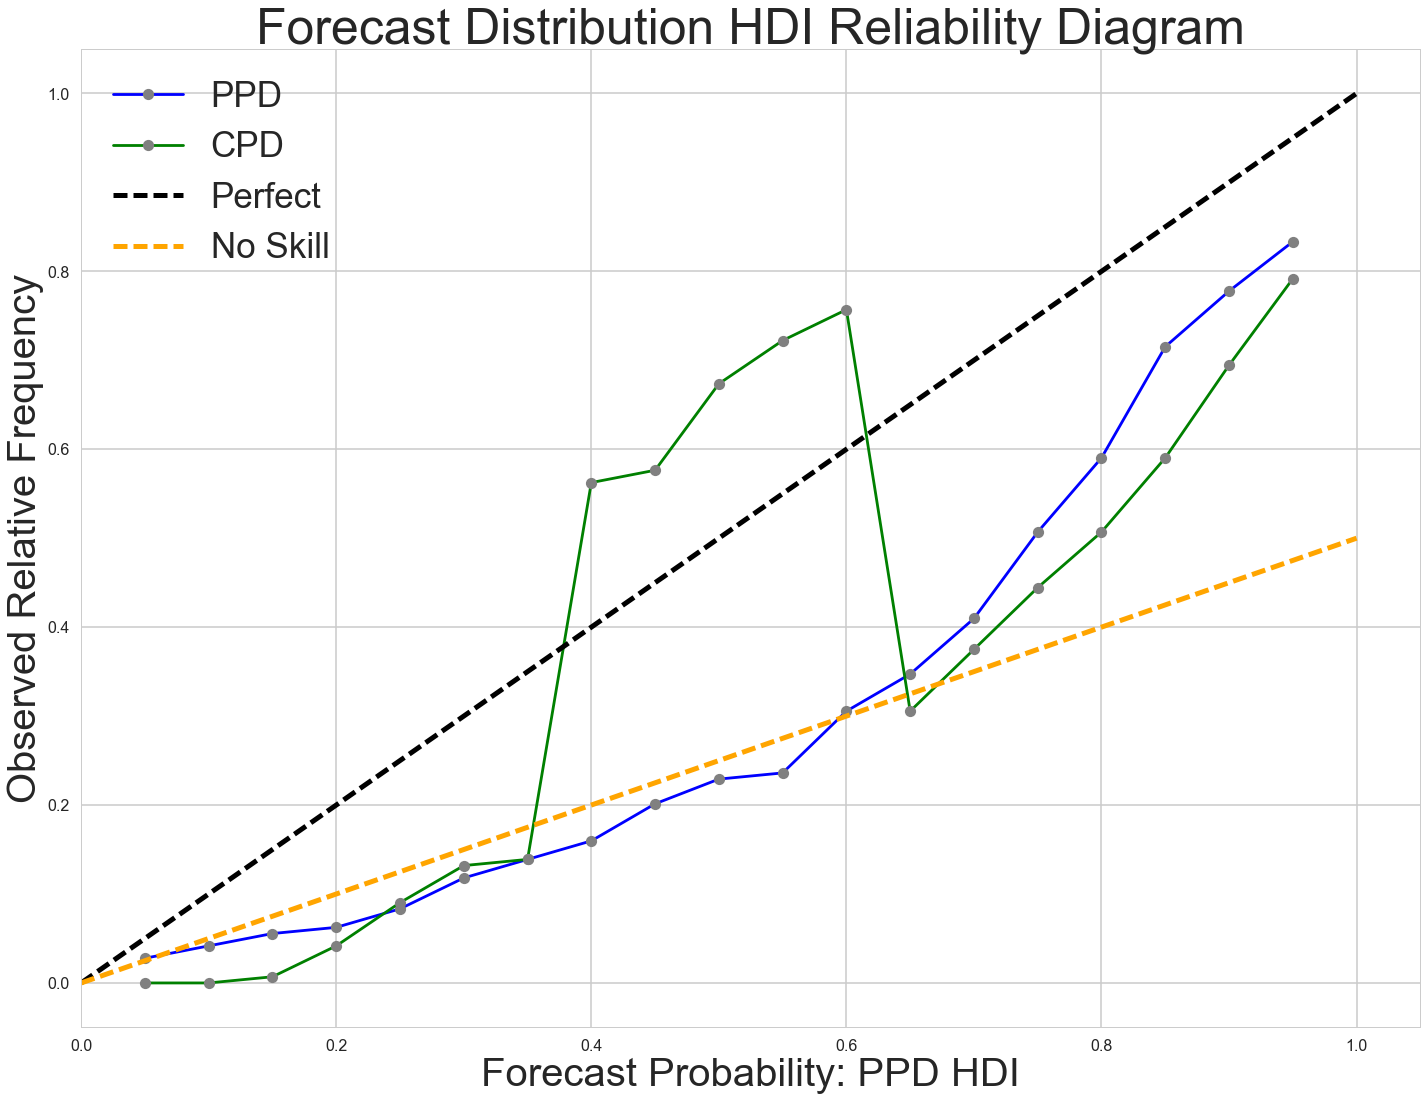

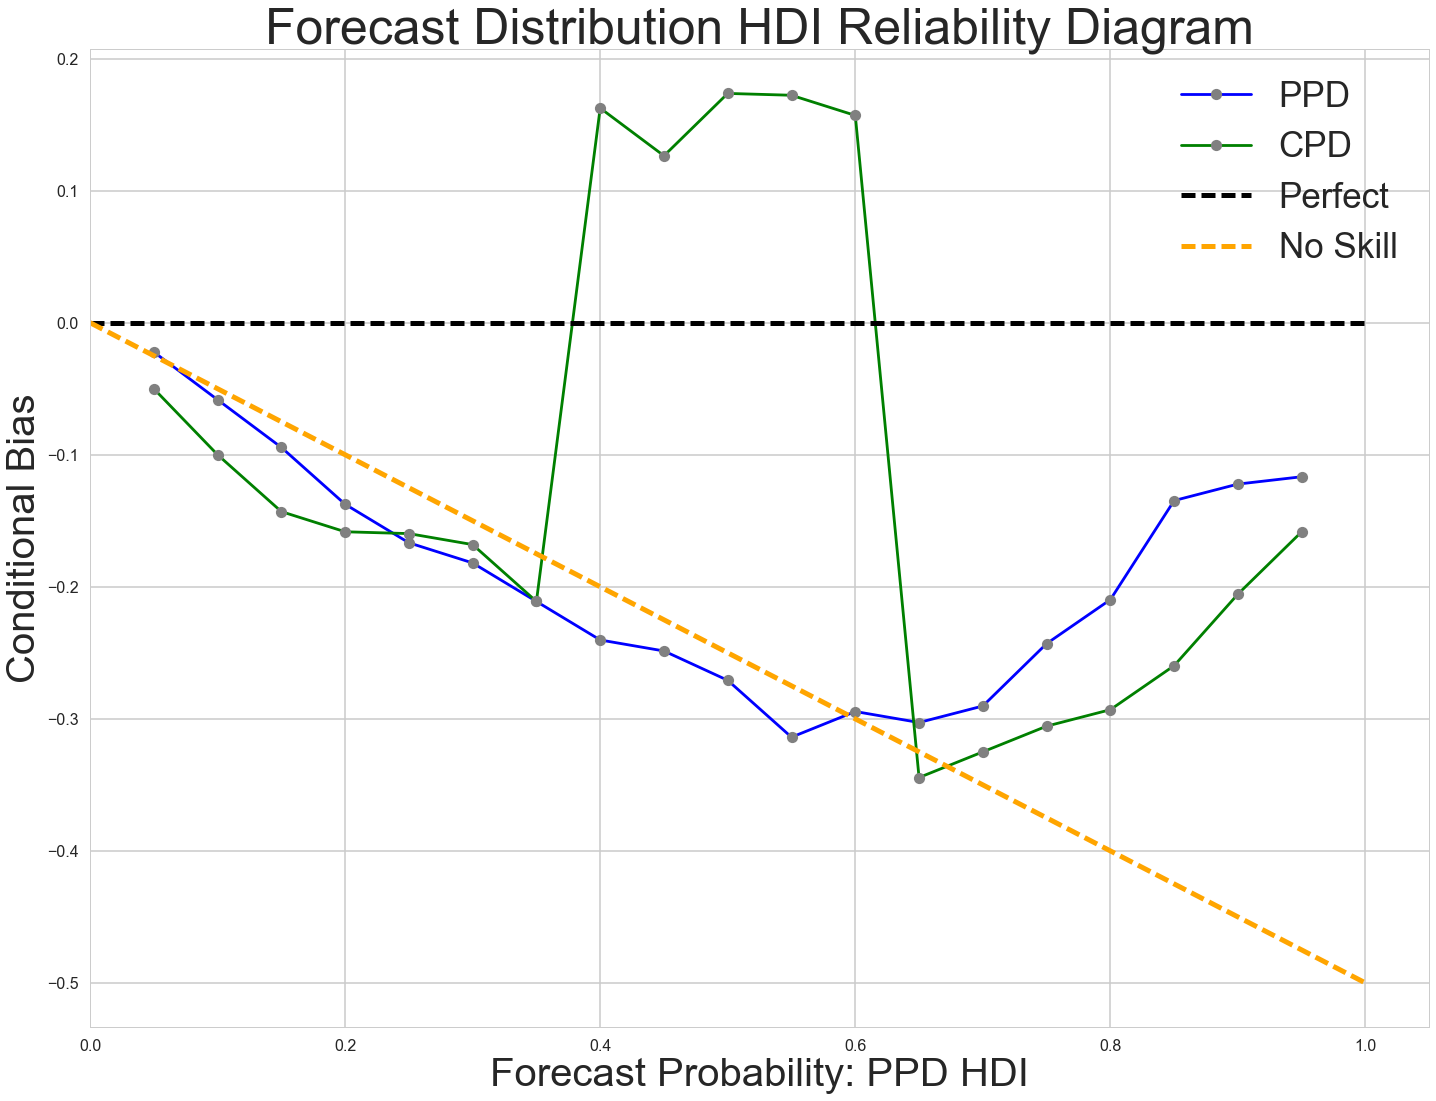

In [6]:
obRelF = np.sum(drF)/drF.shape[0]
obRelC = np.sum(drC)/drC.shape[0]

plt.figure(figsize=(24,18))
plt.plot(np.arange(0.05,1,0.05),obRelF, 
         label='PPD', color = 'blue', marker='o', markerfacecolor='grey')
plt.plot(np.arange(0.05,1,0.05),obRelC, 
         label='CPD', color = 'green', marker='o', markerfacecolor='grey')
plt.plot(np.arange(0,1.05,0.05),np.arange(0,1.05,0.05), 
         label='Perfect', color = 'black', lw=5, ls = '--')
plt.plot(np.arange(0,1.05,0.05),0.5*np.arange(0,1.05,0.05), 
         label='No Skill', color = 'orange', lw=5, ls = '--')

plt.legend(prop={'size':35})
plt.title('Forecast Distribution HDI Reliability Diagram', fontsize=50)
plt.xlabel('Forecast Probability: PPD HDI', fontsize=40)
plt.ylabel('Observed Relative Frequency', fontsize=40)
plt.gca().set_xlim(left=0)

plt.figure(figsize=(24,18))
plt.plot(np.arange(0.05,1,0.05),obRelF - np.arange(0.05,1.0,0.05), 
         label='PPD', color = 'blue', marker='o', markerfacecolor='grey')
plt.plot(np.arange(0.05,1,0.05),obRelC - np.arange(0.05,1.0,0.05), 
         label='CPD', color = 'green', marker='o', markerfacecolor='grey')
plt.plot(np.arange(0,1.05,0.05),np.zeros((1,np.arange(0,1.05,0.05).size)).ravel(), 
         label='Perfect', color = 'black', lw=5, ls = '--')
plt.plot(np.arange(0,1.05,0.05),0.5*np.arange(0,1.05,0.05) - np.arange(0,1.05,0.05), 
         label='No Skill', color = 'orange', lw=5, ls = '--')

plt.legend(prop={'size':35})
plt.title('Forecast Distribution HDI Reliability Diagram', fontsize=50)
plt.xlabel('Forecast Probability: PPD HDI', fontsize=40)
plt.ylabel('Conditional Bias', fontsize=40)
plt.gca().set_xlim(left=0)

In [8]:
# Brier Skill Score for all kernels
brierAll_ppd = np.mean(ds.bsiF)
brierAll_climo = np.mean(ds.bsiC)
brierSkillAll = skill_score(brierAll_ppd,brierAll_climo,0)

NameError: name 'skill_score' is not defined

In [ ]:
# MAE Skill Score for all kernels
absAll_ppd = np.mean(ds.error_abs)
absAll_climo = np.mean(ds.error_climo)
absAll = skill_score(absAll_ppd,absAll_climo,0)

In [ ]:
# MSE Skill Score for all kernels (i.e., reduction of variance)
sqAll_ppd = np.mean(ds.error_sqf)
sqAll_climo = np.mean(ds.error_sqc)
rovAll = skill_score(sqAll_ppd,sqAll_climo,0)

In [ ]:
brierSkillAll

In [ ]:
absAll

In [ ]:
rovAll

In [ ]:
ds_groups = ds.groupby('tau')

print('Valid colormap taus: ')
for tau,group in ds_groups:
    
    print(int(tau))

In [ ]:
plot_fcst(10)

In [ ]:
ds['fo'] =  ds.ppd - ds.obs

sns.lmplot(x="ppd", y="fo", hue="grid_type", data=ds, markers=["o", "o"], size = 20);
xLim = plt.xlim()
yLim = plt.ylim()
plt.plot(plt.xlim(),array([0,0]), label='Perfect', color = 'black', ls = ':')
plt.legend(prop={'size':35})
plt.title('Surface Reflectance Forecast-Observation Scatter Plot', fontsize=50);
plt.xlabel('Forecast', fontsize=40);
plt.ylabel('Forecast - Observed', fontsize=40);
plt.gca().set_xlim(xLim)
plt.gca().set_ylim(yLim)

plt.figure(figsize=(24,18))
plt.plot(ds.ppd[ds['grid_type']=='land'],ds.ppd[ds['grid_type']=='land'] - ds.obs[ds['grid_type']=='land'], "o", label='Land', markerfacecolor='green', mew = 0.5, mec = 'grey')
plt.plot(ds.ppd[ds['grid_type']=='sea'],ds.ppd[ds['grid_type']=='sea'] - ds.obs[ds['grid_type']=='sea'], "o", label='Sea', markerfacecolor='blue', mew = 0.5, mec = 'grey')
xLim = plt.xlim()
yLim = plt.ylim()
plt.plot(plt.xlim(),array([0,0]), label='Perfect', color = 'black', ls = ':')

plt.legend(prop={'size':35})
plt.title('Forecast Scatter Plot | Bayesian PPD Means', fontsize=50)
plt.xlabel('Forecast', fontsize=40)
plt.ylabel('Forecast - Observed', fontsize=40)
plt.gca().set_xlim(xLim)
plt.gca().set_ylim(yLim)

In [ ]:
# Draw a nested violinplot and split the violins for easier comparison
plt.figure(figsize=(20,15))
sns.violinplot(x="cluster", y="error_abs", hue="grid_type", data=ds, split=True,
               inner="quart", palette={"sea": "b", "land": "g"})
sns.despine(left=True)
plt.title('Cluster Distribution of Absolute Forecast Error', fontsize=40)
plt.xlabel('Cluster Group', fontsize=30)
plt.ylabel('Absolute Error', fontsize=30)
plt.gca().set_ylim(bottom=0)

In [ ]:
# Draw a nested violinplot and split the violins for easier comparison
plt.figure(figsize=(20,15))
sns.violinplot(x="valid", y="error_abs", hue="grid_type", data=ds, split=True,
               inner="quart", palette={"sea": "b", "land": "g"})
sns.despine(left=True)
plt.title('Temporal Distribution of Absolute Forecast Error', fontsize=40)
plt.xlabel('Valid Time [Z]', fontsize=30)
plt.ylabel('Absolute Error', fontsize=30)
plt.gca().set_ylim(bottom=0)

In [ ]:
# Draw a nested violinplot and split the violins for easier comparison
plt.figure(figsize=(20,15))
sns.violinplot(x="pos_row", y="error_abs", hue="grid_type", data=ds, split=True,
               inner="quart", palette={"sea": "b", "land": "g"})
sns.despine(left=True)
plt.title('Row Distribution of Absolute Forecast Error', fontsize=40)
plt.xlabel('Row Position', fontsize=30)
plt.ylabel('Absolute Error', fontsize=30)
plt.gca().set_ylim(bottom=0)

In [ ]:
# Draw a nested violinplot and split the violins for easier comparison
plt.figure(figsize=(20,15))
sns.violinplot(x="pos_col", y="error_abs", hue="grid_type", data=ds, split=True,
               inner="quart", palette={"sea": "b", "land": "g"})
sns.despine(left=True)
plt.title('Column Distribution of Absolute Forecast Error', fontsize=40)
plt.xlabel('Column Position', fontsize=30)
plt.ylabel('Absolute Error', fontsize=30)
plt.gca().set_ylim(bottom=0)

In [ ]:
# Draw a heatmap with the numeric values in each cell
plt.figure(figsize=(20,15))
sns.heatmap(ds.pivot_table(index='pos_row', columns='pos_col', values='error_abs', aggfunc='mean'),
            annot=True, linewidths=.5)
plt.title('Surface Reflectance Forecast | Absolute Error', fontsize=40)
plt.xlabel('Column Position', fontsize=30)
plt.ylabel('Row Position', fontsize=30)

In [ ]:
# Draw a heatmap with the numeric values in each cell
plt.figure(figsize=(20,15))
sns.heatmap(ds.pivot_table(index='pos_row', columns='pos_col', values='ppi', aggfunc='mean'),
            annot=True, linewidths=.5)
plt.title('Probability of Cloud', fontsize=40)
plt.xlabel('Column Position', fontsize=30)
plt.ylabel('Row Position', fontsize=30)

In [ ]:
DS = ds.copy(deep=True)

DS[['bsi']] = np.exp(DS[['bsi']])

# Draw a heatmap with the numeric values in each cell
plt.figure(figsize=(20,15))
sns.heatmap(DS.pivot_table(index='pos_row', columns='pos_col', values='bsi', aggfunc='mean'),
            annot=True, linewidths=.5)
plt.title('Cloud Brier Scores', fontsize=40)
plt.xlabel('Column Position', fontsize=30)
plt.ylabel('Row Position', fontsize=30)

In [ ]:
# Draw a heatmap with the numeric values in each cell
plt.figure(figsize=(20,15))
sns.heatmap(ds.pivot_table(index='pos_col', columns='valid', values='error_abs', aggfunc='mean'),
            annot=True, linewidths=.5)
plt.title('Surface Reflectance Forecast Error', fontsize=40)
plt.xlabel('Valid Time [Z]', fontsize=30)
plt.ylabel('Column Position', fontsize=30)

In [ ]:
# Draw a heatmap with the numeric values in each cell
plt.figure(figsize=(20,15))
sns.heatmap(ds.pivot_table(index='pos_row', columns='valid', values='error_abs', aggfunc='mean'),
            annot=True, linewidths=.5)
plt.title('Surface Reflectance Forecast Error', fontsize=40)
plt.xlabel('Valid Time [Z]', fontsize=30)
plt.ylabel('Row Position', fontsize=30)

In [ ]:
# Draw a heatmap with the numeric values in each cell
plt.figure(figsize=(20,15))
sns.heatmap(ds.pivot_table(index='pos_row', columns='cluster', values='error_abs', aggfunc='mean'),
            annot=True, linewidths=.5)
plt.title('Surface Reflectance Forecast Error', fontsize=40)
plt.xlabel('Cluster Group', fontsize=30)
plt.ylabel('Row Position', fontsize=30)

In [ ]:
# Draw a heatmap with the numeric values in each cell
plt.figure(figsize=(20,15))
sns.heatmap(ds.pivot_table(index='pos_col', columns='cluster', values='error_abs', aggfunc='mean'),
            annot=True, linewidths=.5)
plt.title('Surface Reflectance Forecast Error', fontsize=40)
plt.xlabel('Cluster Group', fontsize=30)
plt.ylabel('Column Position', fontsize=30)

In [ ]:
# Draw a categorical scatterplot to show each observation
plt.figure(figsize=(20,15))
sns.swarmplot(x="cluster", y="error_abs", hue="grid_type", data=ds)
plt.title('Surface Reflectance Forecast Error', fontsize=40)
plt.xlabel('Cluster Group', fontsize=30)
plt.ylabel('Absolute Error', fontsize=30)

In [ ]:
# Draw a categorical scatterplot to show each observation
plt.figure(figsize=(20,15))
sns.swarmplot(x="valid", y="error_abs", hue="grid_type", data=ds)
plt.title('Surface Reflectance Forecast Error', fontsize=40)
plt.xlabel('Valid Time [Z]', fontsize=30)
plt.ylabel('Absolute Error', fontsize=30)

In [ ]:
# Draw a categorical scatterplot to show each observation
plt.figure(figsize=(20,15))
sns.swarmplot(x="pos_row", y="error_abs", hue="grid_type", data=ds)
plt.title('Surface Reflectance Forecast Error', fontsize=40)
plt.xlabel('Row Position', fontsize=30)
plt.ylabel('Absolute Error', fontsize=30)

In [ ]:
# Draw a categorical scatterplot to show each observation
plt.figure(figsize=(20,15))
sns.swarmplot(x="pos_col", y="error_abs", hue="grid_type", data=ds)
plt.title('Surface Reflectance Forecast Error', fontsize=40)
plt.xlabel('Column Position', fontsize=30)
plt.ylabel('Absolute Error', fontsize=30)

In [ ]:
mean_1 = np.mean(ds.error_abs[ds['grid_type']=='sea'])
mean_2 = np.mean(ds.error_abs[ds['grid_type']=='land'])

plt.figure(figsize=(20,15))
sns.distplot(ds.error_abs[ds['grid_type']=='sea'], label='sea')
sns.distplot(ds.error_abs[ds['grid_type']=='land'], label='land')
yLim = plt.gca().get_ylim()
plt.plot([mean_1,mean_1], [yLim[0], yLim[1]], color='b', linestyle= '--', label=r'$\mu_{Sea}$')
plt.plot([mean_2,mean_2], [yLim[0], yLim[1]], color='g', linestyle= '--', label=r'$\mu_{Land}$')
plt.legend()
plt.title('Surface Reflectance Forecast | Absolute Error of PPD Means', fontsize=40)
plt.xlabel('Absolute Error', fontsize=30)
plt.ylabel('Relative Frequency', fontsize=30)
plt.gca().set_xlim(left=0)

In [ ]:
mean_1 = np.mean(ds.error_climo[ds['grid_type']=='sea'])
mean_2 = np.mean(ds.error_climo[ds['grid_type']=='land'])

plt.figure(figsize=(20,15))
sns.distplot(ds.error_climo[ds['grid_type']=='sea'], label='sea')
sns.distplot(ds.error_climo[ds['grid_type']=='land'], label='land')
yLim = plt.gca().get_ylim()
plt.plot([mean_1,mean_1], [yLim[0], yLim[1]], color='b', linestyle= '--', label=r'$\mu_{Sea}$')
plt.plot([mean_2,mean_2], [yLim[0], yLim[1]], color='g', linestyle= '--', label=r'$\mu_{Land}$')
plt.legend()
plt.title('Surface Reflectance | Climo Forecast | Absolute Error', fontsize=40)
plt.xlabel('Absolute Error', fontsize=30)
plt.ylabel('Relative Frequency', fontsize=30)
plt.gca().set_xlim(left=0)

In [ ]:
plt.figure(figsize=(20,15))
sns.distplot(ds.ppd[ds['grid_type']=='sea'], label='sea')
sns.distplot(ds.ppd[ds['grid_type']=='land'], label='land')
plt.legend()
plt.title('Surface Reflectance | PPD-mean Forecasts', fontsize=40)
plt.xlabel('PPD Mean', fontsize=30)
plt.ylabel('Relative Frequency', fontsize=30)
plt.gca().set_xlim(left=0)

In [ ]:
plt.figure(figsize=(20,15))
sns.distplot(ds.obs[ds['grid_type']=='sea'], label='sea')
sns.distplot(ds.obs[ds['grid_type']=='land'], label='land')
plt.legend()
plt.title('Surface Reflectance | Observations', fontsize=40)
plt.xlabel('Observed', fontsize=30)
plt.ylabel('Relative Frequency', fontsize=30)
plt.gca().set_xlim(left=0)